# Instrucctions

## Select mode to run the code
The code allows to be runned in different modes:
* Exploratory: It will run the cell blocks related to the exploration of the data.
* Tuning: It hill run the cell blocks related to the Hyperparameter-Tuning.
* Training: It will run cell blocks used to train the models, using the best parameters found in the previous stage.
* Evaluation: It will run the code related to evaluation measures and comparison between the available models.
* Best_Classifier: It will allow to run the training for the best model found, and output a result in the Output folder.
* All: Allows to run all the code (be careful, this might take a while!)

It should be noticed that some blocks make no distintion between modes, and they will be runned at all times (libraries, blocks containing useful functions.)
The code will be at 'Best_Classifier' mode by default, allowing the user to run only the useful parts to obtain the Output. The user can use the run-all in Jupyter Notebook knowing that only the parts needed for this function will be runned. However, the user must be warned that the valuable outputs given in the original code will be lost in doing so. If the user wants to check the outputs without running all the code (trust me, this might take a while!, especially 'Tuning' code), this should be done before running in 'Best_Classifier' mode.
Notice that all the figures will be saved in the same folder than the code is placed.

In [12]:
'''Select one mode from the list'''
modes = ['Exploratory', 'Tuning', 'Training', 'Evaluation', 'Best_Classifier','All']
mode = modes[-1] 

# Import libraries

In [8]:
%matplotlib inline
%matplotlib notebook

libraries = []
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#Datasets and arrays
import numpy as np
import pandas as pd
libraries.append('numpy')
libraries.append('pandas')

#Complexity and progress
import time
import tracemalloc
from tqdm.notebook import tqdm
libraries.append('tqdm')

#Pre-processing and Dimensionality reduction
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #not being used
libraries.append('scikit-learn')

#KNN
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
#Logistic Regression
from sklearn.linear_model import LogisticRegression

#Naive Bayes
from sklearn.naive_bayes import GaussianNB

#Decision Tree
from sklearn.tree import DecisionTreeClassifier

#Bagging
from sklearn.ensemble import BaggingClassifier

#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

#AdaBoost
from sklearn.ensemble import AdaBoostClassifier

#Random Forest
from sklearn.ensemble import RandomForestClassifier

#SVC
from sklearn.svm import SVC

#Parameter selection
from sklearn.model_selection import GridSearchCV

#Validation and evaluation
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
libraries.append('more-itertools')

#Formatting and plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-paper')
plt.rcParams["figure.facecolor"] = "w"
libraries.append('matplotlib')
libraries.append('seaborn')

#Files
import h5py
import os
libraries.append('h5py')

#Pthon and library version
import types
import pkg_resources
import sys
from platform import python_version

#Save as pdf
#import nbconvert
#from nbconvert.preprocessors import ExecutePreprocessor

In [3]:
'''To display version of Software being used'''
print('Version of python installed: {}' .format(sys.version))
print('Version of python being used: {}' .format(python_version()))
print('\nNon-built in libraries being used:')

for m in pkg_resources.working_set:
    if m.project_name.lower() in libraries:
        print('{}, version {}'.format(m.project_name,m.version))

Version of python installed: 3.8.10 (default, May 19 2021, 11:01:55) 
[Clang 10.0.0 ]
Version of python being used: 3.8.10

Non-built in libraries being used:
tqdm, version 4.61.1
seaborn, version 0.11.1
scikit-learn, version 0.22.1
pandas, version 1.2.5
numpy, version 1.19.2
more-itertools, version 8.8.0
matplotlib, version 3.3.4
h5py, version 2.10.0


In [9]:
def extract_data(train):
    '''It returns the data and labels. If train is True, the data corresponds to Train set. 
    If train is False, data corresponds to Test set.'''
    
    if train:
        file = ['./Input/train/images_training.h5','./Input/train/labels_training.h5']
        column = ['datatrain','labeltrain']

    else:
        file = ['./Input/test/images_testing.h5','./Input/test/labels_testing_2000.h5']
        column = ['datatest','labeltest']
        
    with h5py.File(file[0],'r') as H:
        data = np.copy(H[column[0]])
    with h5py.File(file[1],'r') as H:
        label = np.copy(H[column[1]])
        
    if not train:
        '''If we are extracting the test Test set, we want to return the labelled set only.'''
        data = data[:2000]
    return data, label

def data_to_df(data):
    '''It returns a pandas dataframe containing the given dataset'''
    df = pd.DataFrame(data, columns=['p'+str(n) for n in range(data.shape[1])])
    return df

def type_classes():
    '''It returns a dictionary with the number of class as key and name of class as value.'''
    type_classes = {0: 'T-shirt/Top',1:'Trouser', 2:'Pullover', 
                    3:'Dress', 4: 'Coat', 5:'Sandal', 6:'Shirt', 7: 'Sneaker', 
                    8: 'Bag', 9:'Ankle boot'}
    return type_classes

def show_sample(number, data, label):
    '''It allows to print a sample with his corresponding label.
    Given a number of example, the dataset and the label data for the dataset,
    it prints an images, with the number, class number and class name as title.'''
    tc  = type_classes()
    plt.rcParams["figure.figsize"] = (4,4)
    data = data.reshape((data.shape[0], 28, 28))
    plt.figure()
    plt.imshow(data[number], cmap=plt.get_cmap('gray'))
    num_class = label[number]
    sample_label = tc[num_class]
    plt.title("Sample #{}\n Class {}: {} ".format(number, num_class, sample_label),fontsize=16)
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    plt.tight_layout()
    plt.show()
    
def normalize(data_train, data_test):
    '''It allows to normalize the data. Given a train and test dataset, it returns
    both dataset (train and test) normalized using the MinMaxScaler fitted using 
    train set.'''
    
    scaler = MinMaxScaler()
    scaler.fit(data_train)

    data_train_norm = scaler.transform(data_train) 
    data_test_norm = scaler.transform(data_test) 
    
    return data_train_norm, data_test_norm

def prepare_data(normalize_data = False):    
    '''Extract and normalize the data if needed. 
    If False is given as an argument, it is not needed to normalize, and the data will be 
    extracted and returned without changes.
    It returns the data train set, label train set, data test set and
    label test set.'''
    data_train, label_train = extract_data(True)
    data_test, label_test = extract_data(False)
    
    if normalize_data:
        data_train, data_test = normalize(data_train, data_test)
        
    return data_train, label_train, data_test, label_test

def explore_data(df_train):    
    ''' It returns a dataset with columns = ['pixel', 'mean','variance','x','y' ]
    using the information contained in the dataset given'''
    pixel = [] 
    mean = []
    var = []
    coordx = []
    coordy = []
    i = 0
    j = 0
    for col, dat in df_train.iteritems():
        pixel.append(col)
        mean.append(dat.mean())
        var.append(dat.var())
        coordx.append(i)
        coordy.append(j)
        j += 1
        if j % 28 == 0:
            i += 1
            j = 0
    df_temp = pd.DataFrame({'pixel':pixel, 'mean': mean, 'variance':var, 'x':coordx, 
                            'y':coordy})
    return df_temp

def plot_mean_and_variance(df_temp):
    '''Given a dataframe that contains the stats for each pixel, it prints a plot of the
    mean and variance'''
    
    fig = plt.figure(figsize=(12,6)) 
    ax = fig.add_subplot(111)
    plt.plot(df_temp['pixel'], df_temp['mean'], c = 'royalblue', alpha=.4, label='mean')
    plt.plot(df_temp['pixel'], df_temp['variance'], c= 'tomato', alpha= .4, 
             label='variance')
    ax.xaxis.set_major_locator(plt.MaxNLocator(30))
    plt.title('Dataset stats')
    plt.ylabel('mean and variance')
    plt.xlabel('Pixels')
    plt.legend()
    plt.show()
    
def plot_bar(labels, color, loc):
    '''Given labels (classes), a color and location (for the bars)
    it prints a plit bar, allowing to agreggate the bars given a different location.'''
    tc = type_classes()
    tc_text = ''
    for n, t in tc.items():
        tc_text = tc_text + ' ' + str(n) + ':' + str(t)
    
    u, cnts = np.unique(labels, return_counts=True)
    idx = np.argsort(u)
    cnts = cnts[idx]*100/len(labels)
    u = u[idx]
    x = np.arange(len(u))
    
    r = -0.5
    if loc == 'right':
        r = r* -1
     
    plt.bar(x + r * 0.35, cnts, align='center', alpha=.7, width=0.35, color = color)
    plt.xticks(x, u, rotation=0,)
    plt.xlabel('Types of clothing\n' + tc_text)
    plt.ylabel('Percentage of the total dataset')
    
def visualise_stratification(label_train, label_test):
    '''It uses plot_bar function to create a plot to visualise stratification of train and 
    test sets.'''
    plt.figure()
    plt.title('Relative amount of pictures per class')
    plot_bar(label_train, '#440154FF', loc='left')
    plot_bar(label_test, '#55C667FF', loc='right')
    plt.legend([
        'train ({0} photos)'.format(len(label_train)), 
        'test ({0} photos)'.format(len(label_test))
    ])
    plt.show()
    
def heatmap_pixel(df,type_stat):
    '''It prints a heatmap with the mean per pixel location'''
    plt.figure()
    df = df.pivot("y", "x", type_stat)
    ax = sns.heatmap(df, cmap="YlGnBu")
    plt.title('{} value per pixel coordenates'.format(str(type_stat).capitalize()))
    plt.show()

# Retrieve the data and check dimension

<IPython.core.display.Javascript object>


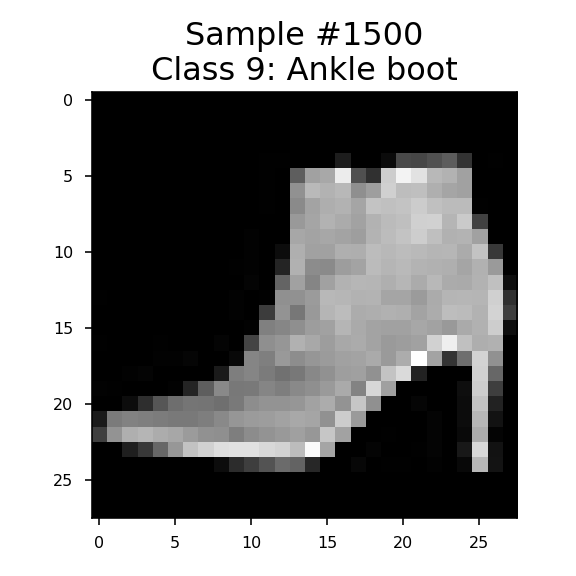

In [11]:
'''Retrieve the data'''
data_train, label_train, data_test, label_test = prepare_data(False)

df_train = data_to_df(data_train)
df_test = data_to_df(df_train)
'''Check if the shape is correct'''
assert data_train.shape == (30000, 784), 'Shape of data for training is wrong.'
assert label_train.shape == (30000,), 'Shape of labels for training is wrong'
assert data_test.shape == (2000, 784), 'Shape of data for testing is wrong.'
assert label_test.shape == (2000,), 'Shape of labels for testing is wrong'

if (mode == 'Exploratory') | (mode == 'All'):
    show_sample(1500, data_train, label_train)
    plt.savefig('Example.png',dpi=300)

# Explore the data

In [6]:
if (mode == 'Exploratory') | (mode == 'All'):
    '''Explore the data'''
    print('DATA TRAIN:\n',df_train.isnull().any().describe()) #no null values in the dataset. 
    print('Max Value:',df_train.max().max(),'\nMin Value:',df_train.min().min(),
          '\nMean: {:.2f}'.format(df_train.mean().mean()), 
          '\nVariance: {:.2f}'.format(df_train.var().var()),'\n')
    print('DATA TEST:\n',df_test.isnull().any().describe(), '\n')
    print('Max Value:',df_test.max().max(),'\nMin Value:',df_test.min().min(),
          '\nMean: {:.2f}'.format(df_test.mean().mean()), 
          '\nVariance: {:.2f}'.format(df_test.var().var()),'\n')
   
    print('LABELS TRAIN SET:\nContains missing values:', np.isnan(label_train).any())
    print('Max Value:',label_train.max(),'\nMin Value:',label_train.min())
    print('\nLABELS TEST SET:\nContains missing values:', np.isnan(label_test).any())
    print('Max Value:',label_test.max(),'\nMin Value:',label_test.min())

DATA TRAIN:
 count       784
unique        1
top       False
freq        784
dtype: object
Max Value: 1.0 
Min Value: 0.0 
Mean: 0.29 
Variance: 0.00 

DATA TEST:
 count       784
unique        1
top       False
freq        784
dtype: object 

Max Value: 1.0 
Min Value: 0.0 
Mean: 0.29 
Variance: 0.00 

LABELS TRAIN SET:
Contains missing values: False
Max Value: 9 
Min Value: 0

LABELS TEST SET:
Contains missing values: False
Max Value: 9 
Min Value: 0


<IPython.core.display.Javascript object>


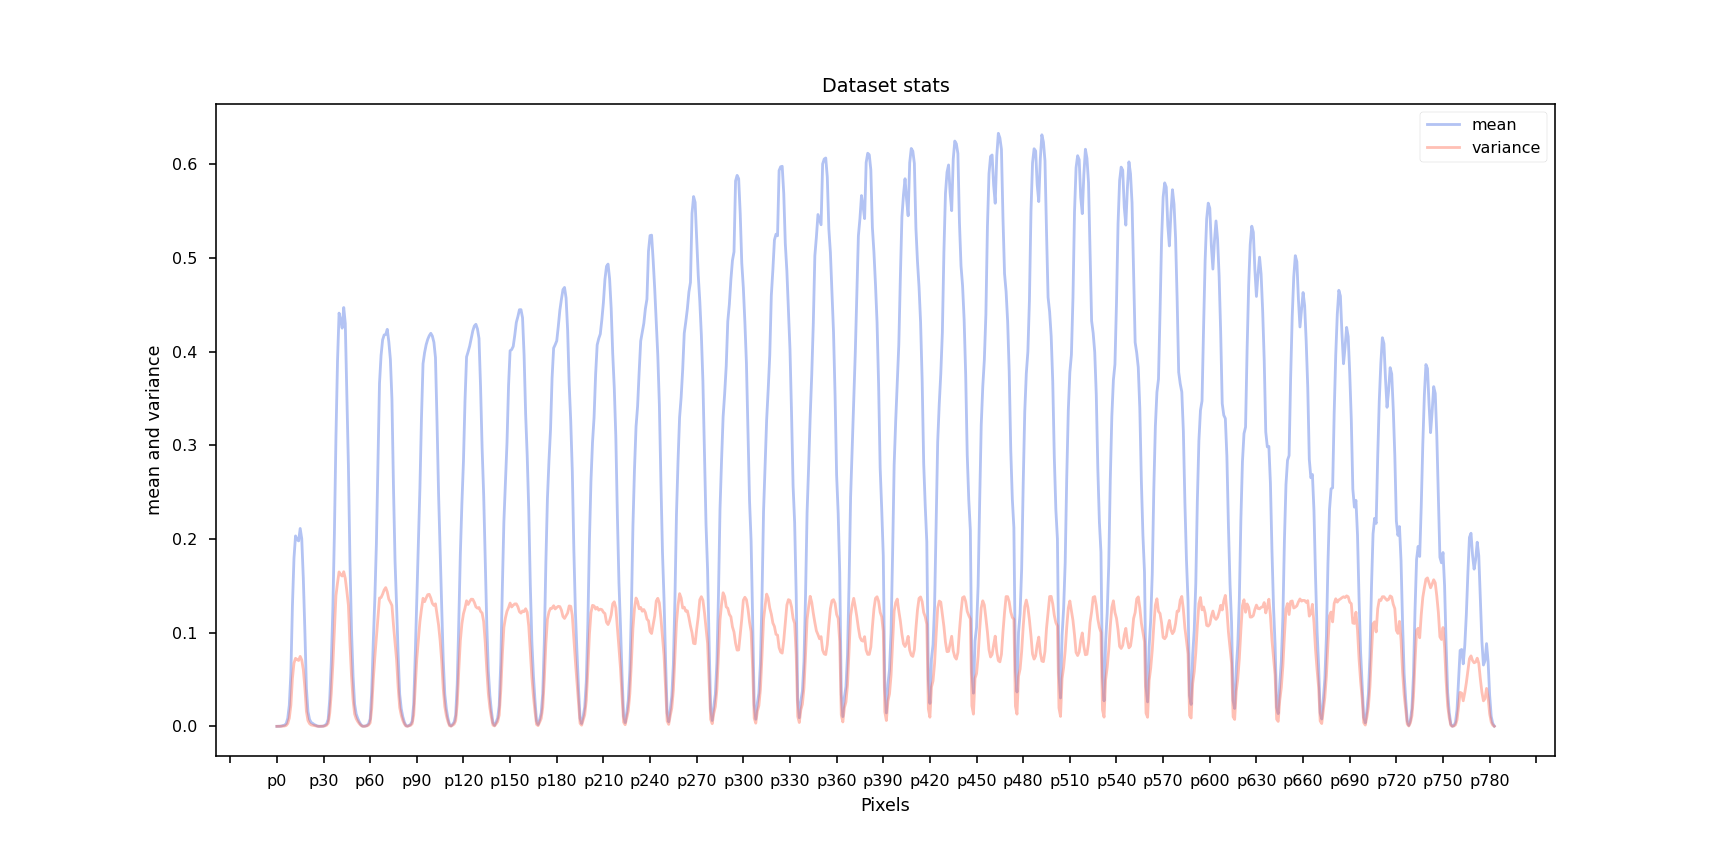

In [7]:
if (mode == 'Exploratory') | (mode == 'All'):
    df_stats = explore_data(df_train)
    plot_mean_and_variance(df_stats)
    plt.savefig('MeanAndVariance.png', dpi=300)
    plt.show()

<IPython.core.display.Javascript object>


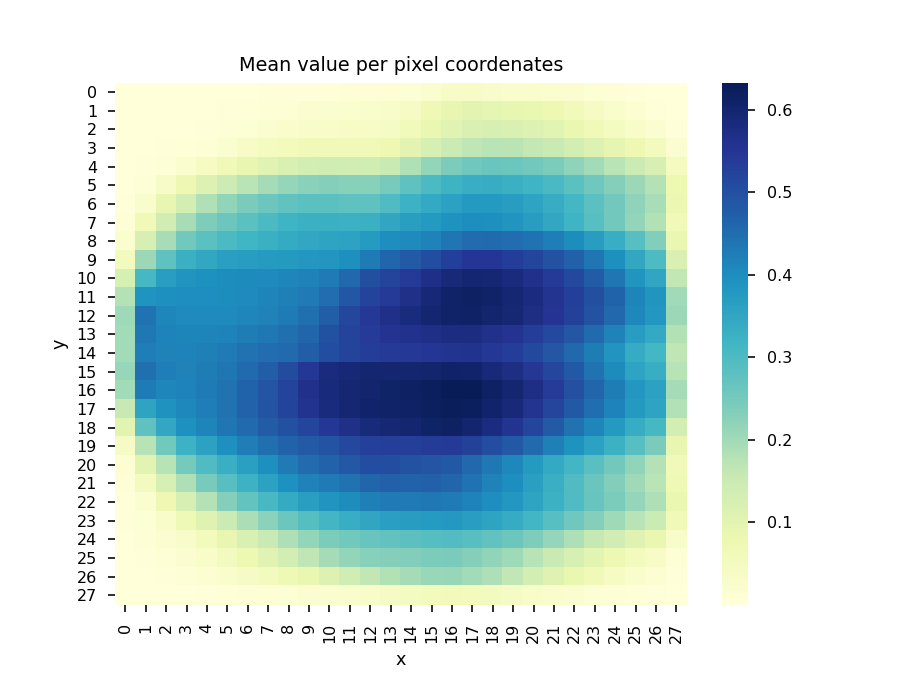

<IPython.core.display.Javascript object>


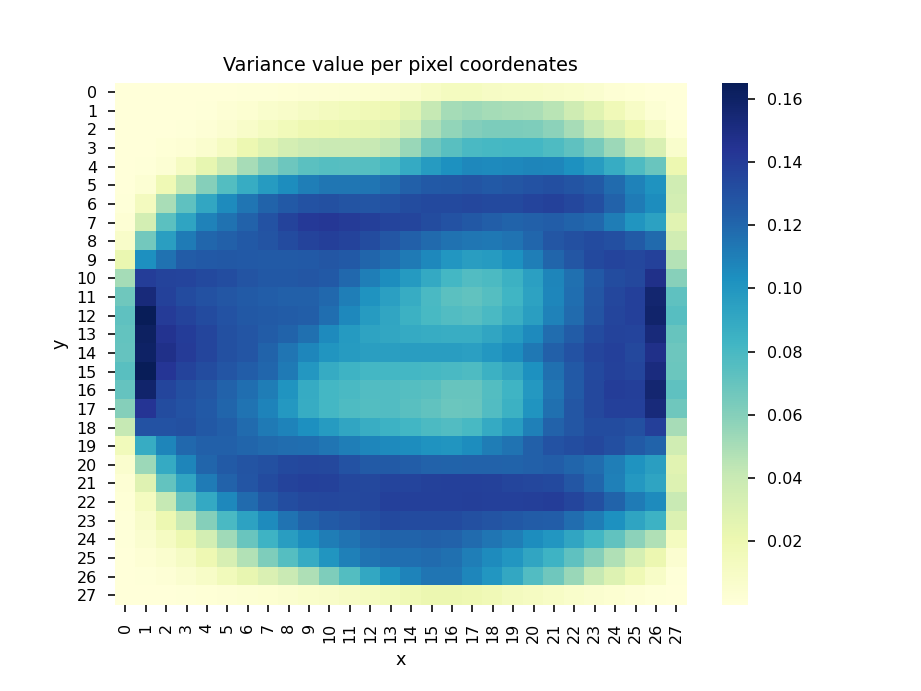

In [8]:
if (mode == 'Exploratory') | (mode == 'All'):
    df_stats = explore_data(df_train)
    
    heatmap_pixel(df_stats,'mean')
    plt.savefig('HeatmapMean.png', dpi=300)
    plt.show()
    
    heatmap_pixel(df_stats,'variance')
    plt.savefig('HeatmapVariance.png', dpi=300)

    plt.show()

<IPython.core.display.Javascript object>


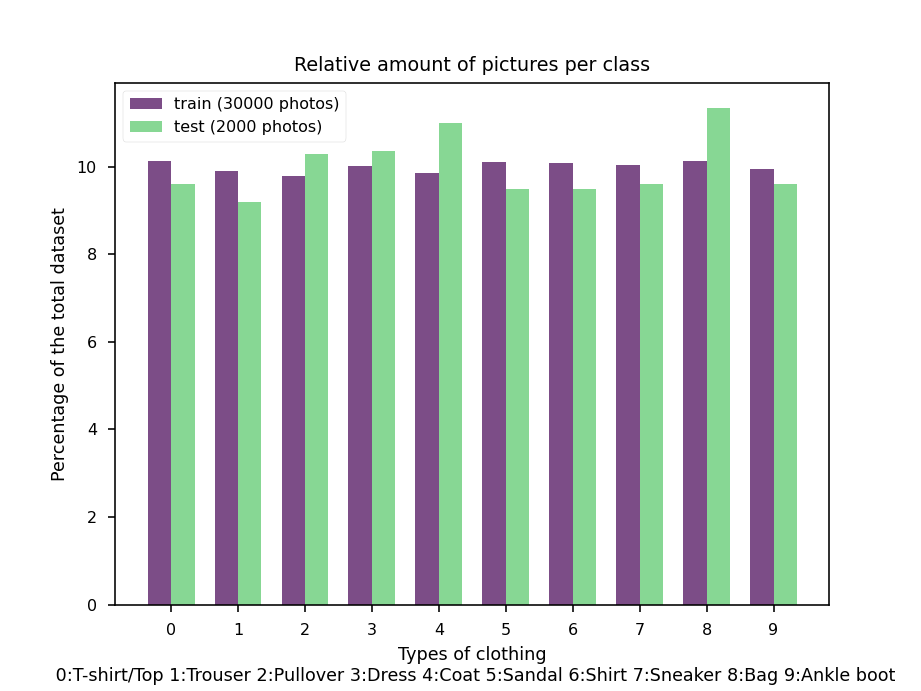

In [9]:
if (mode == 'Exploratory') | (mode == 'All'):
    visualise_stratification(label_train, label_test)
    plt.savefig('Stratification.png', dpi=300)
    plt.show()

# Pre-process the images

In [13]:
def reduc_dim_pca(df, n_components):
    '''It uses PCA to reduce the dimensionality to a n_components from the given dataset.
    It returns the reduced dataset and the resulting pca fitted object dimred of type'''
    dimred = PCA(n_components=n_components, random_state=13)
    reduced = dimred.fit_transform(df)
    print("The new dimension of our dataset is:",reduced.shape)
    return reduced, dimred

def visualise_reduction_dimension(reduced, dimred):
    '''It plots a scatter of the first two components after PCA is applied.
    The arguments needed are the reduced dataset, and the pca fitted object (dimred)'''
    tc = type_classes()
    fig = plt.figure(figsize=(8,5))
    plt.scatter(reduced[:, 0], reduced[:, 1],        
    c=label_train, edgecolor='none', alpha=.5, cmap=plt.cm.get_cmap('jet', len(tc)))
    plt.colorbar(ticks=range(len(tc)), label='Class')
    plt.title('PCA\n First and Second Principal Components\n Explaining {:.2f}% variance'.
              format(
    (dimred.explained_variance_ratio_[0]+dimred.explained_variance_ratio_[1])*100))
    
def visualise_cumulative_variance_explained(df):
    '''It plots two figures using dual axes:
    Red: Cumulative variance explained after one more component is added. Uses right y axis.
    Blue: Variance explained per component. Usis left axis.
    Components are ordered in such way the first one is explaining the most variance, 
    and the last component is explaining the least variance. This order is provided by the
    PCA method.
    '''
    fig, ax1 = plt.subplots(figsize=(8,5))
    get_dims = PCA().fit(df)
    num_dims = len(get_dims.components_)
    
    ax1.set_xlabel('Dimensions')
    ax1.set_ylabel('Variance per each dimension', color='#2534a7')
    ax1.tick_params(axis='y', labelcolor='#2534a7')
    plt.bar(range(1, num_dims + 1), get_dims.explained_variance_ratio_)
    
    ax2 = ax1.twinx()
    ax2.step(range(1,len(get_dims.components_) + 1), 
             np.cumsum(get_dims.explained_variance_ratio_), color='tomato')
    ax2.set_ylabel('Cum variance', color='tomato')
    ax2.tick_params(axis='y', labelcolor='tomato')
    plt.title('Number of dimensions vs the cumulative variance explained')
    plt.xlabel('Dimensions') 
    plt.ylabel('Variance')
    plt.show()

## Dimensionality reduction

<IPython.core.display.Javascript object>


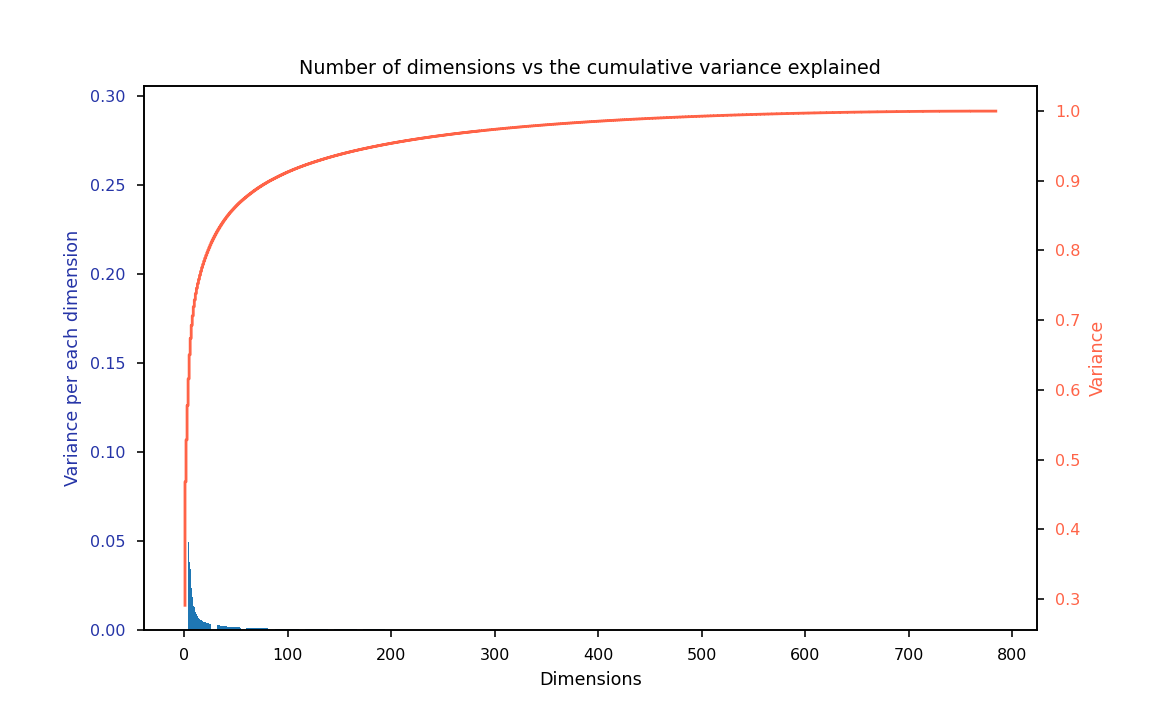

In [11]:
if (mode == 'Exploratory') | (mode == 'All'):
    visualise_cumulative_variance_explained(df_train) 
    plt.savefig('CumVarianceExplained.png', dpi=300)

The new dimension of our dataset is: (30000, 188)


<IPython.core.display.Javascript object>


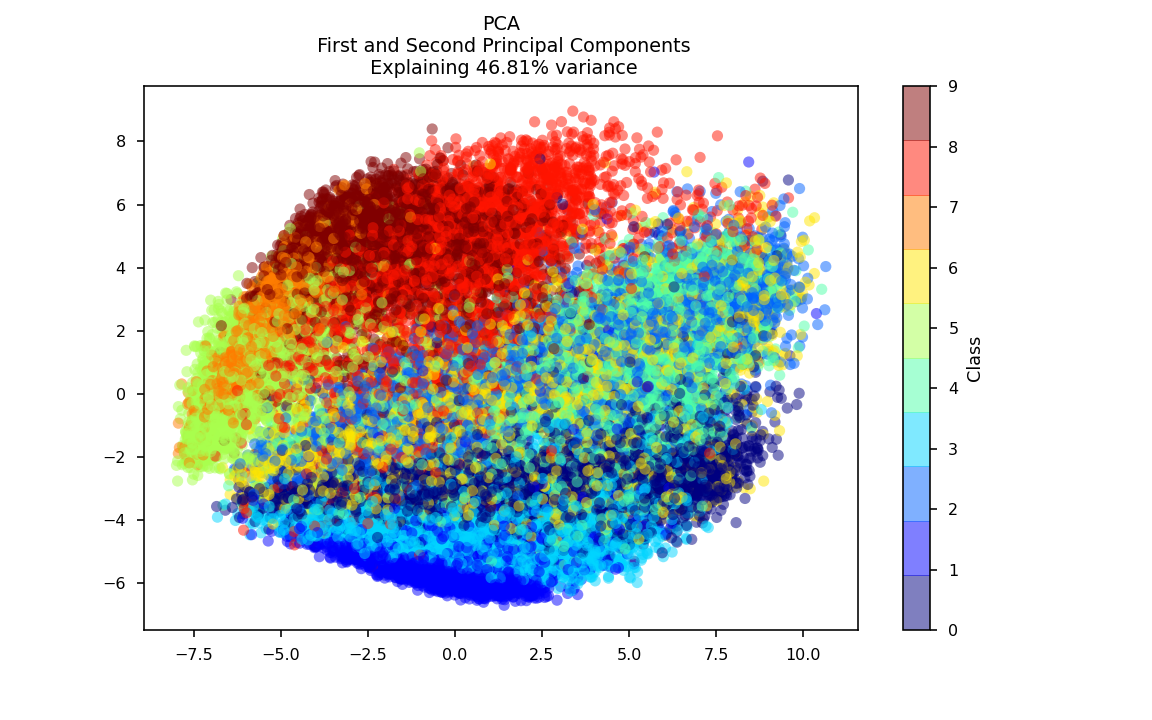

Explained variance: 94.98


In [12]:
if (mode == 'Exploratory') | (mode == 'All'):
    '''Using PCA to reduce the dimensionality of the problem'''
    n_components=188 #Preserves 95%
    reduced, dimred = reduc_dim_pca(df_train, n_components)
    visualise_reduction_dimension(reduced, dimred)
    plt.savefig('PCAfirstcomponents.png',dpi=300)
    plt.show()
    print('Explained variance: {:.2f}'.format(dimred.explained_variance_ratio_.sum()*100))

<IPython.core.display.Javascript object>


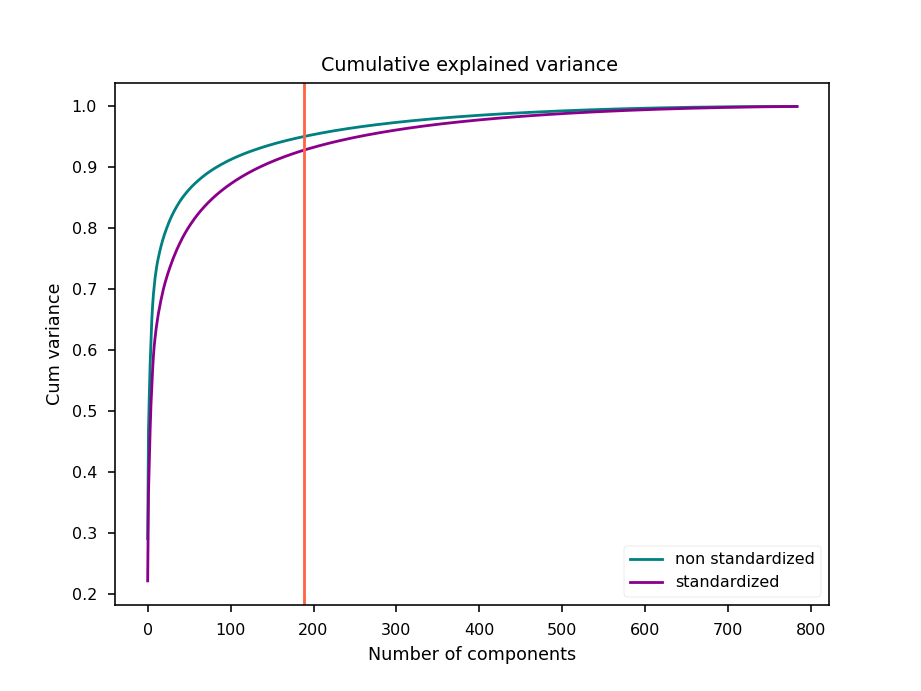

In [13]:
if (mode == 'Exploratory') | (mode == 'All'):
    plt.figure()
    scaler = StandardScaler()
    scaler.fit(df_train)
    df_st = scaler.transform(df_train)
    pca_standardized = PCA().fit(df_st)
    pca_non_standardized = PCA().fit(df_train)
    plt.plot(np.cumsum(pca_non_standardized.explained_variance_ratio_), 
             label = 'non standardized', color = 'teal')
    plt.plot(np.cumsum(pca_standardized.explained_variance_ratio_),
            label = 'standardized', color='darkmagenta')
    plt.axvline(x=188, color = 'tomato')
    plt.xlabel('Number of components')
    plt.ylabel('Cum variance')
    plt.legend()
    plt.title('Cumulative explained variance ')
    plt.savefig('NumComponentsSelected.png', dpi=300)
    plt.show()

In [14]:
def prepare_pca(data_train, n_components, random_state = 13):
    '''Given a data_train set, and a number of components, it will use a random_state seed 
    to pre-process the de data using PCA.
    It will return the pca object ready to be fitted
    '''
    pca = PCA(n_components=n_components, random_state=random_state)
    return pca

# Parameter Tuning using Grid Cross-Validation
Models to be implemented are:
* K-nearest neighbors (knn)
* Multinomial Logistic Regression (log)
* Naïve Bayes (nb)
* Decision Tree (dt)
* Bagging (bag)
* Random Forest (rfo)
* Support Vector Machine Classifier (svc)
* AdaBoost (ada)

In [15]:
def Grid_cross_val(model, X_train_reduced, y_train):
    '''It performs grid search of the best parameters using Cross-Validation
    for the given name of model. Available options are:
    model = ['knn', 'log', 'nb', 'dt', 'bag', 'rfo', 'svc','ada'].
    It prints the tuning_grid being used, and the best classifier found.'''
    
    if model == 'knn':
        tuning_grid = {'n_neighbors': [5, 9],
                      'p': [1, 2], 
                      'algorithm': ['kd_tree', 'ball_tree'], 
                      'metric' : ['minkowski'],
                      'weights' : ['uniform', 'distance'] }
        clsf = KNeighborsClassifier(leaf_size=300, n_jobs = -1)
        
    elif model == 'log':
        tuning_grid = {'solver': ['saga', 'sag', 'newton-cg'],
                      'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                      'warm_start': [False, True]}
        clsf = LogisticRegression(random_state=13, n_jobs=-1)
        
    elif model == 'nb':
        tuning_grid = {'var_smoothing': np.logspace(0,-10, num=100)}
        clsf = GaussianNB()
        
    elif model == 'dt':
        tuning_grid = {'criterion' : ['gini', 'entropy'],
                      'splitter' : ['best', 'random'],
                      'max_depth' : [12, 13, 14]}
        clsf = DecisionTreeClassifier(random_state=13)
        
    elif model == 'bag':
        tuning_grid = {'base_estimator__max_depth' : [1, 2, 5, 8, 10],
                      'max_samples' : [0.05, 0.1, 0.2],
                      'max_features' : [0.05, 0.1, 0.2]}
        clsf = BaggingClassifier(DecisionTreeClassifier(random_state=13), n_jobs= -1,
                                 n_estimators = 100)
        
    elif model == 'rfo':
        tuning_grid = {'criterion' : ['gini', 'entropy'],
                      'max_depth' : [1, 5, 10],
                      'max_features' : ['sqrt', 'log2'],
                      'n_estimators' : [100, 500]}
        clsf = RandomForestClassifier(random_state=13, n_jobs= -1)
        
    elif model == 'svc':
        tuning_grid = {'kernel' : ['poly', 'rbf'], 
                      'C': [1, 10, 100],
                      'degree' : [1, 2, 3, 10],
                     'gamma': ['scale']}
        clsf = SVC(random_state=13)
        
    elif model == 'ada':
        tuning_grid = {'learning_rate' : [0.01, 0.1, 0.3, 1]}
        clsf = AdaBoostClassifier(DecisionTreeClassifier(random_state=13),random_state=13,
                                  n_estimators=100)
        
    tuned_model = GridSearchCV(clsf, tuning_grid, cv=10, return_train_score=False, n_jobs= -1)
    tuned_model.fit(X_train_reduced, y_train)
    
    print("Parameters used for tuning:\n{}".format(tuning_grid))
    print("Best tuned model:\n{}".format(tuned_model.best_estimator_))

In [9]:
if (mode == 'Tuning') | (mode == 'All'):
    '''To run Grid search Cross-Validation across one model at a time
    we prepare de data and perform PCA first '''

    #Extract the data
    X_train, y_train, X_test, y_test = prepare_data(True)

    #Pre-Process the data
    n_components = 188 #Will explain 95% of the variance.

    pca = prepare_pca(X_train, n_components)
    pca.fit(X_train, y_train)

    X_train_reduced = pca.transform(X_train)
    X_test_reduced = pca.transform(X_test)

In [ ]:
if (mode == 'Tuning') | (mode == 'All'):
    Grid_cross_val('rfo', X_train_reduced, y_train)

Parameters used for tuning:
{'criterion': ['gini', 'entropy'], 'max_depth': [1, 5, 10], 'max_features': ['sqrt', 'log2'], 'n_estimators': [100, 500]}
Best tuned model:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)


In [ ]:
if (mode == 'Tuning') | (mode == 'All'):
    Grid_cross_val('svc', X_train_reduced, y_train)

Parameters used for tuning:
{'kernel': ['poly', 'rbf'], 'C': [1, 10, 100], 'degree': [1, 2, 3, 10], 'gamma': ['scale']}
Best tuned model:
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=13, shrinking=True, tol=0.001,
    verbose=False)


In [19]:
if (mode == 'Tuning') | (mode == 'All'):
    Grid_cross_val('dt', X_train_reduced, y_train)

Parameters used for tuning:
{'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [12, 13, 14]}
Best tuned model:
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=13, splitter='best')


In [20]:
if (mode == 'Tuning') | (mode == 'All'):
    Grid_cross_val('nb', X_train_reduced, y_train)

Parameters used for tuning:
{'var_smoothing': array([1.00000000e+00, 7.92482898e-01, 6.28029144e-01, 4.97702356e-01,
       3.94420606e-01, 3.12571585e-01, 2.47707636e-01, 1.96304065e-01,
       1.55567614e-01, 1.23284674e-01, 9.77009957e-02, 7.74263683e-02,
       6.13590727e-02, 4.86260158e-02, 3.85352859e-02, 3.05385551e-02,
       2.42012826e-02, 1.91791026e-02, 1.51991108e-02, 1.20450354e-02,
       9.54548457e-03, 7.56463328e-03, 5.99484250e-03, 4.75081016e-03,
       3.76493581e-03, 2.98364724e-03, 2.36448941e-03, 1.87381742e-03,
       1.48496826e-03, 1.17681195e-03, 9.32603347e-04, 7.39072203e-04,
       5.85702082e-04, 4.64158883e-04, 3.67837977e-04, 2.91505306e-04,
       2.31012970e-04, 1.83073828e-04, 1.45082878e-04, 1.14975700e-04,
       9.11162756e-05, 7.22080902e-05, 5.72236766e-05, 4.53487851e-05,
       3.59381366e-05, 2.84803587e-05, 2.25701972e-05, 1.78864953e-05,
       1.41747416e-05, 1.12332403e-05, 8.90215085e-06, 7.05480231e-06,
       5.59081018e-06, 4.430621

In [13]:
if (mode == 'Tuning') | (mode == 'All'):
    Grid_cross_val('knn', X_train_reduced, y_train)

Parameters used for tuning:
{'n_neighbors': [5, 9], 'p': [1, 2], 'algorithm': ['kd_tree', 'ball_tree'], 'metric': ['minkowski'], 'weights': ['uniform', 'distance']}
Best tuned model:
KNeighborsClassifier(algorithm='kd_tree', leaf_size=300, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=1,
                     weights='distance')


In [10]:
if (mode == 'Tuning') | (mode == 'All'):
    Grid_cross_val('log', X_train_reduced, y_train)

Parameters used for tuning:
{'solver': ['saga', 'sag', 'newton-cg'], 'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'warm_start': [False, True]}
Best tuned model:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l1', random_state=13,
                   solver='saga', tol=0.0001, verbose=0, warm_start=False)


In [ ]:
if (mode == 'Tuning') | (mode == 'All'):
    Grid_cross_val('ada', X_train_reduced, y_train)

Parameters used for tuning:
{'learning_rate': [0.01, 0.1, 0.3, 1]}
Best tuned model:
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                 

In [ ]:
if (mode == 'Tuning') | (mode == 'All'):
    Grid_cross_val('bag', X_train_reduced, y_train)

Parameters used for tuning:
{'base_estimator__max_depth': [1, 2, 5, 8, 10], 'max_samples': [0.05, 0.1, 0.2], 'max_features': [0.05, 0.1, 0.2]}
Best tuned model:
BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf

# Train the models using the best parameters
After we concluded our Hyperparameter tuning phase, we use the best parameters found to train our classifiers.

In [16]:
def train(model, X_train_reduced, y_train):
    '''Given a model, and a train set, train labels,
    already pre-processed, it trains the classifiers using the best parameters setted.
    The available models are in the following model list:
    model = ['knn', 'log', 'nb', 'dt', 'bag', 'rfo', 'gb', 'ada', 'svc']
    
    The function will return:
    fitted_model: The classifier trained using the selected model.
    training_time: A measure of time that took to train the fitted_model
    memory_info: Information of the memory used in the process of training
    traceback_stats:
    size: Memory usage after the model was trained.
    peak: Peak of memory after the model was trained.
    '''
    tracemalloc.start()
    start = time.time()

    if model == 'knn':
        fitted_model = KNeighborsClassifier(algorithm='kd_tree',leaf_size=300, 
                                            metric='minkowski', n_jobs=-1, n_neighbors=5, 
                                            p=1,weights='distance')
    elif model == 'log':
        fitted_model = LogisticRegression(C=1.0, class_weight=None, dual=False, 
                                          fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l1', random_state=13,
                   solver='saga', tol=0.0001, verbose=0, warm_start=False)
              
    elif model == 'nb':
        fitted_model = GaussianNB(var_smoothing=0.00023101297000831605)
        
    elif model == 'dt':
        fitted_model = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=13, splitter='best')
        
    elif model == 'bag': #This is not validated
        fitted_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=13,
                                                        splitter='best'),
                  bootstrap=True, bootstrap_features=False, max_features=0.2,
                  max_samples=0.2, n_estimators=100, n_jobs=-1, oob_score=False,
                  random_state=None, verbose=0, warm_start=False)
        
    elif model == 'gb': #This is not validated
        fitted_model = GradientBoostingClassifier(max_depth=1, n_estimators=100, learning_rate=0.1, 
                                    random_state=13)
    elif model == 'rfo': 
        fitted_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)
                                              
    elif model == 'ada': 
        fitted_model = AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                                                         random_state=13,
                                                         splitter='best'),
                   learning_rate=0.01, n_estimators=100, random_state=13)
                                                        
    elif model == 'svc':
        fitted_model = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=1, gamma='scale', kernel='rbf',
                           max_iter=-1, probability=False, random_state=13, shrinking=True, tol=0.001,
                           verbose=False)

    fitted_model.fit(X_train_reduced, y_train)
    
    end = time.time()
    training_time = (end - start)/60
    
    memory_info = tracemalloc.take_snapshot()
    traceback_stats = memory_info.statistics('traceback')
    
    size, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    tracemalloc.clear_traces()
    #tracemalloc.reset_peak() #this only works with Python 3.9

    return fitted_model, training_time, memory_info, traceback_stats, size, peak

In [21]:
if (mode == 'Training') | (mode == 'All'):
    '''To train the models'''

    #Extract the data
    X_train, y_train, X_test, y_test = prepare_data(True)

    #Pre-Process the data
    n_components = 188 

    pca = prepare_pca(X_train, n_components)
    pca.fit(X_train, y_train)

    X_train_reduced = pca.transform(X_train)
    X_test_reduced = pca.transform(X_test)

    #Train the models using best parameters
    model = ['knn', 'log', 'nb', 'dt', 'bag', 'rfo', 'gb', 'ada', 'svc']
    models_dic = {}
    tt_train = {}
    mi_train = {}
    ts_train = {}
    fs_train = {}
    fp_train = {}
    tqdm.pandas()
    for m in tqdm(model):
        m_t, tt, mi, ts, fs, fp = train(m, X_train_reduced, y_train)
        models_dic[m] = m_t
        tt_train[m] = tt
        mi_train[m] = mi
        ts_train[m] = ts
        fs_train[m] = fs
        fp_train[m] = fp

  0%|          | 0/9 [00:00<?, ?it/s]

In [22]:
if (mode == 'Training') | (mode == 'All'):
    print(models_dic)

{'knn': KNeighborsClassifier(algorithm='kd_tree', leaf_size=300, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=1,
                     weights='distance'), 'log': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l1', random_state=13,
                   solver='saga', tol=0.0001, verbose=0, warm_start=False), 'nb': GaussianNB(priors=None, var_smoothing=0.00023101297000831605), 'dt': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=13, splitte

# Evaluation and comparison

In [17]:
def get_confusion_matrix(confusion_m, classes, model_name):
    plt.rcParams.update(plt.rcParamsDefault)
    plt.figure()
    
    plt.imshow(confusion_m, interpolation='nearest', cmap=plt.cm.viridis)
    plt.title('Confusion matrix: {}'.format(model_name))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=65)
    plt.yticks(tick_marks, classes)

    formatting = 'd'
    threshold = confusion_m.max() / 2.
    for i, j in itertools.product(range(confusion_m.shape[0]), 
                                  range(confusion_m.shape[1])):
        plt.text(j, i, format(confusion_m[i, j], formatting),
                 horizontalalignment="center",
                 color="black" if confusion_m[i, j] > threshold else "white")

    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    
def color_names():
    colors = {'knn':'#3dbcd9', 'log':'#37c2aa', 'nb': '#6fa146', 'dt': '#8abc5f',
              'bag': '#bfaf3e', 'rfo':'#e75b41','gb': '#e896aa' ,
              'ada': '#cf9dcf', 'svc': '#9cabe6'}
    return colors

In [19]:
if (mode == 'Evaluating') | (mode == 'All'):
    models_acc_train = {}
    tqdm.pandas()
    for name, model in tqdm(models_dic.items()):
        acc = model.score(X_train_reduced , y_train)*100
        models_acc_train[name]= acc
        
    models_acc_test = {}
    tqdm.pandas()
    for name, model in tqdm(models_dic.items()):
        acc = model.score(X_test_reduced , y_test)*100
        models_acc_test[name]= acc

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


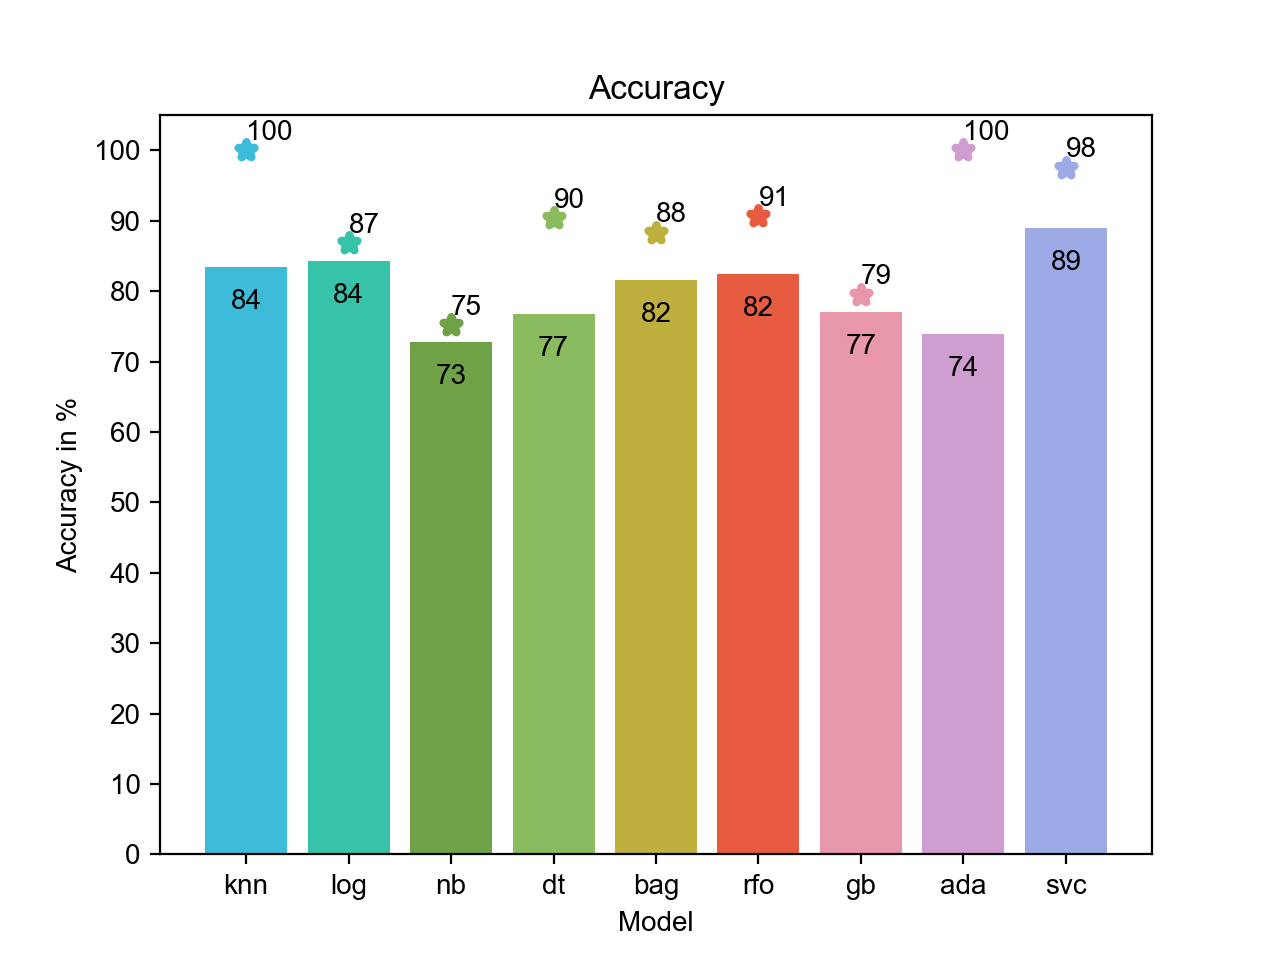

In [20]:
if (mode == 'Evaluating') | (mode == 'All'):
    plt.rcParams.update(plt.rcParamsDefault)
    plt.figure()
    tqdm.pandas()
    colors = color_names()
    for name, acc in tqdm(models_acc_test.items()):
        plt.bar(name, acc, label = name, color = colors[name])
        plt.text(name, acc-5, '{:.0f}'.format(acc), horizontalalignment='center', 
                 verticalalignment='center')
    for name, acc in tqdm(models_acc_train.items()):
        plt.scatter(name, acc,label = name, color = colors[name], marker = '*', linewidths = 3)
        plt.text(name, acc+2.5, '{:.0f}'.format(acc), horizontalalignment='left', 
                 verticalalignment='center')
    n = 100
    plt.yticks(np.linspace(0, n, n//9))
    plt.xlabel('Model')
    plt.ylabel('Accuracy in %')
    plt.title('Accuracy')
    plt.savefig('AccuracyTestData.png',dpi=300)
    plt.show() #Compare with accuracy on training data

In [21]:
if (mode == 'Evaluating') | (mode == 'All'):
    predictions = {}
    tt_pred = {}
    mi_pred = {}
    ts_pred = {}
    fs_pred = {}
    fp_pred = {}
    tqdm.pandas()
    for name, model in tqdm(models_dic.items()):
        tracemalloc.start()
        start = time.time()

        y_pred = model.predict(X_test_reduced)
        predictions[name]= y_pred
    
        end = time.time()
        pred_time = (end - start)/60
        
        memory_info = tracemalloc.take_snapshot()
        traceback_stats = memory_info.statistics('traceback')
    
        size, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        tracemalloc.clear_traces()
        
        tt_pred[name]= pred_time
        mi_pred[name]= memory_info
        ts_pred[name]= traceback_stats
        fs_pred[name]= size
        fp_pred[name]= peak

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


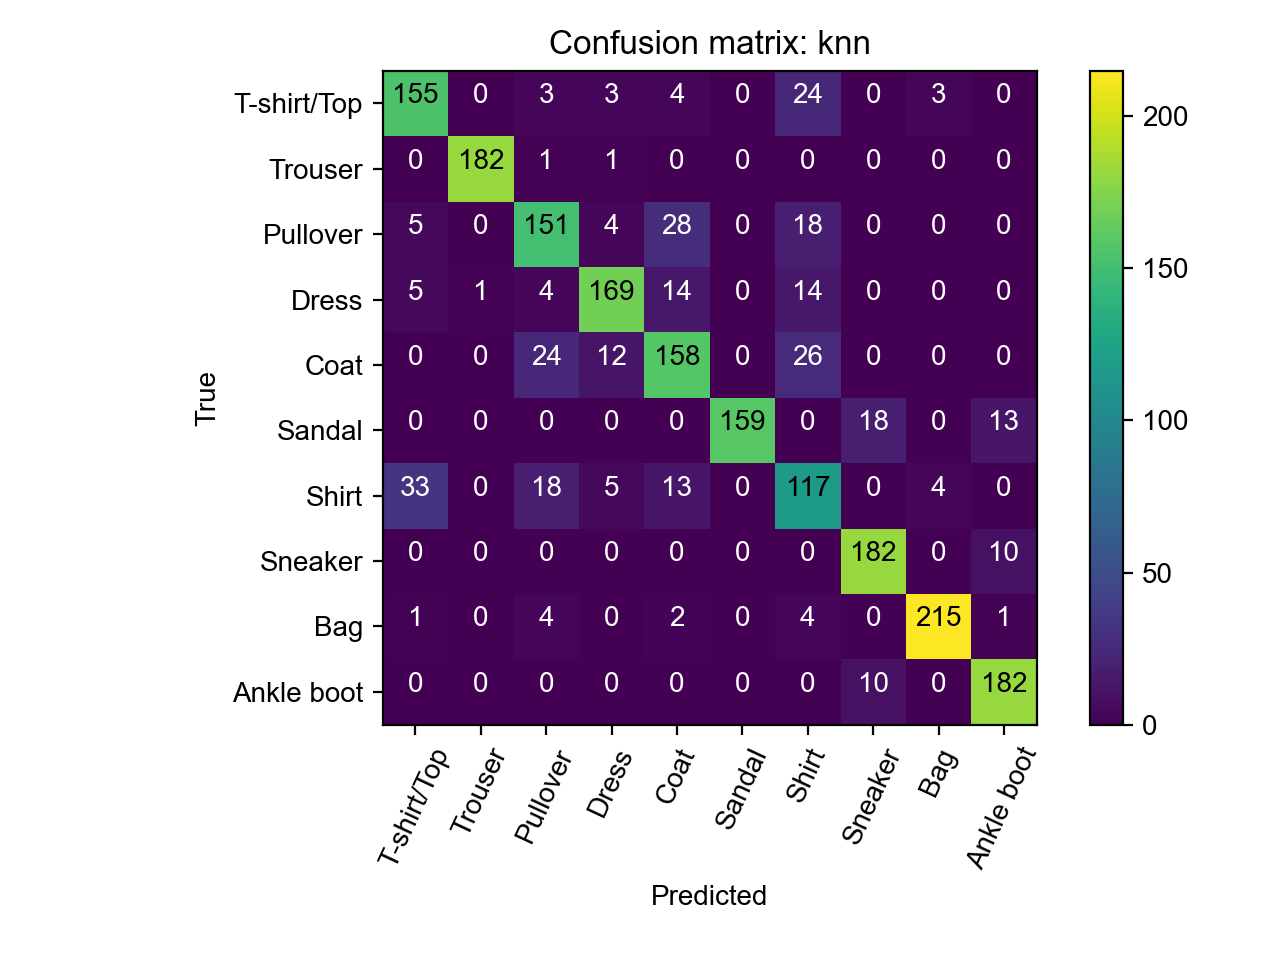

<IPython.core.display.Javascript object>


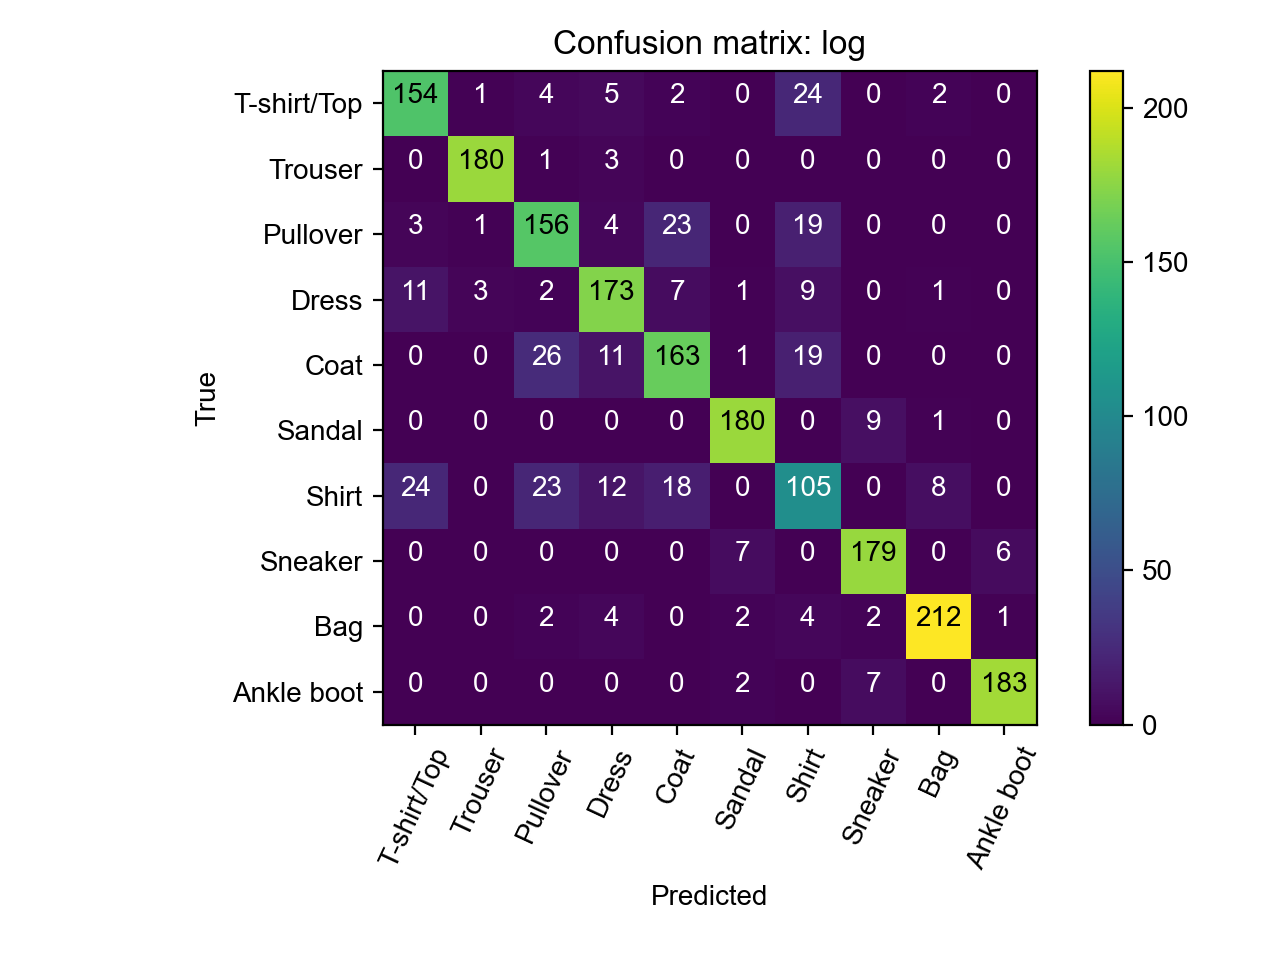

<IPython.core.display.Javascript object>


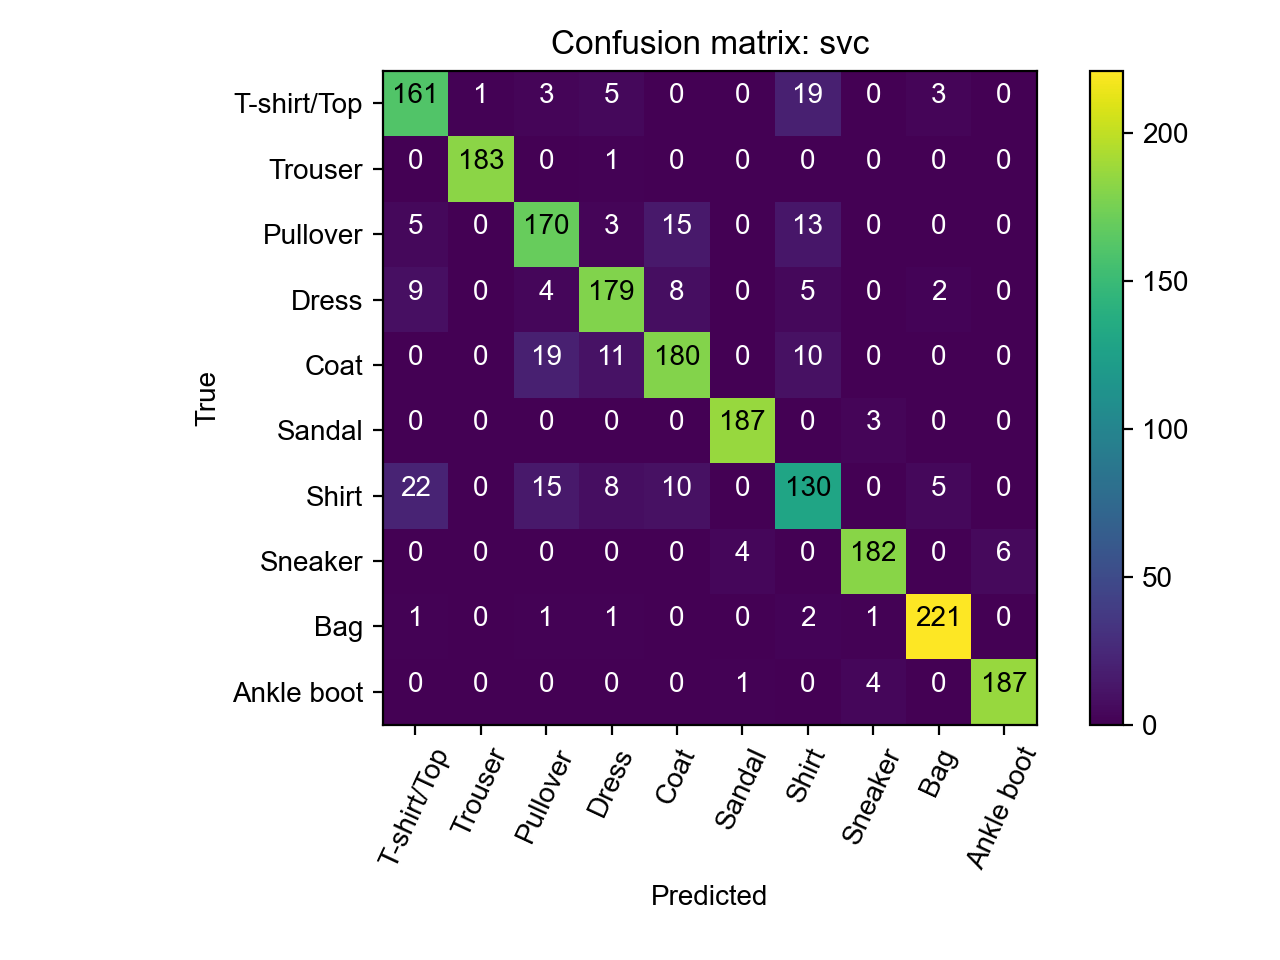

In [22]:
if (mode == 'Evaluating') | (mode == 'All'):
    # Evaluation: Confusion Matrix
    model = ['knn','log', 'svc']
    tqdm.pandas()
    for m in tqdm(model):
        y_pred = predictions[m]
        cnm = confusion_matrix(label_test, y_pred,labels=np.unique(y_pred))
        get_confusion_matrix(cnm, list(type_classes().values()), m)
        plt.savefig('ConfMatrix_'+ m +'.png',dpi=300)
        plt.show()

<IPython.core.display.Javascript object>


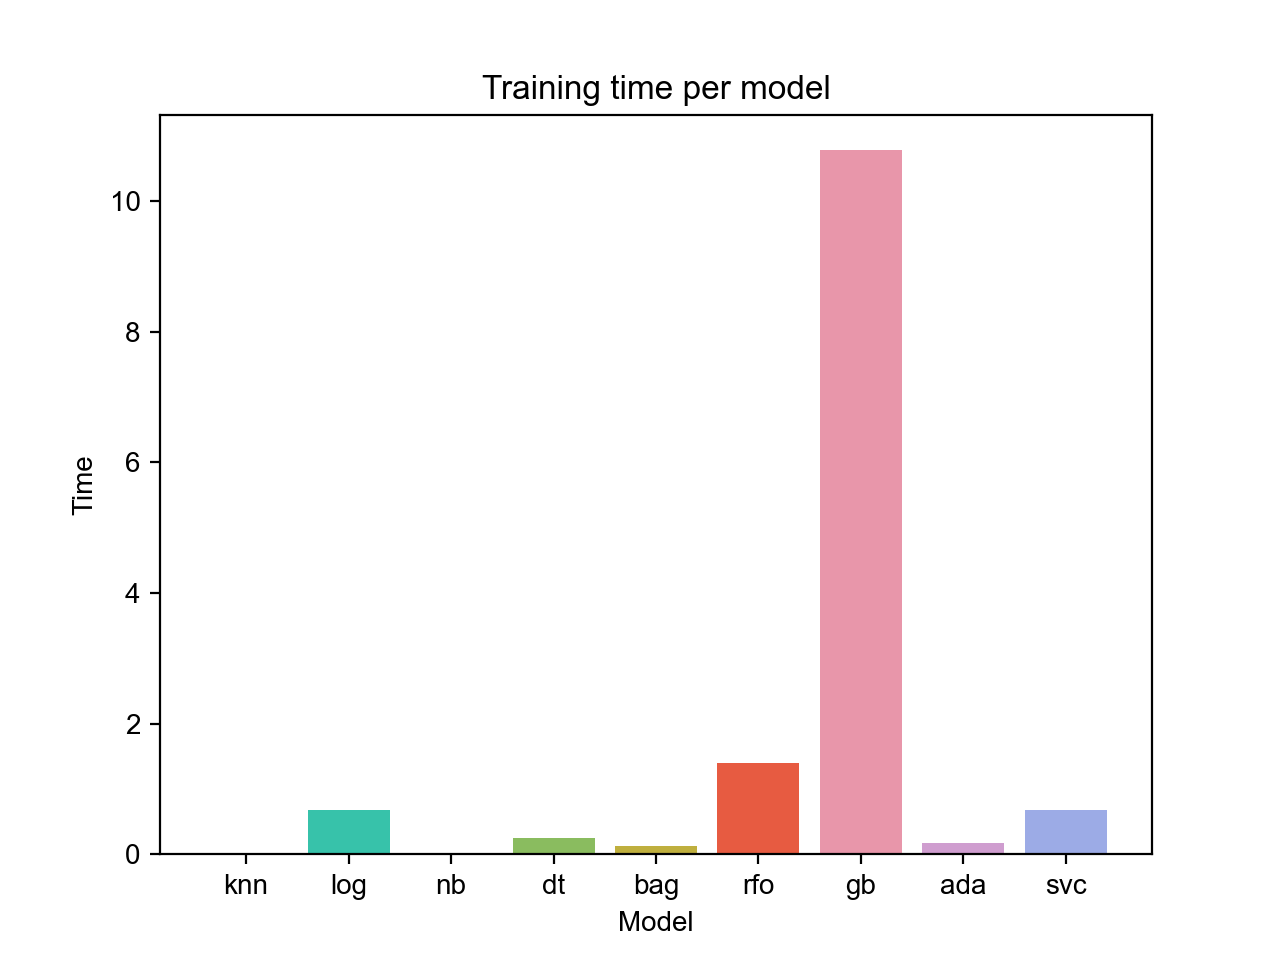

In [23]:
if (mode == 'Evaluating') | (mode == 'All'):
    #Evaluation: Training Time
    colors = color_names()
    plt.figure()
    for name, tt in tt_train.items():
        plt.bar(name, tt, label=name, color = colors[name])
    plt.title('Training time per model')
    plt.xlabel('Model')
    plt.ylabel('Time')
    plt.savefig('TrainingTime.png',dpi=300)
    plt.show()

knn : 46013042
log : 217149
nb : 38097
dt : 4816
bag : 450466
rfo : 487723
gb : 451312
ada : 22142
svc : 16307741


<IPython.core.display.Javascript object>


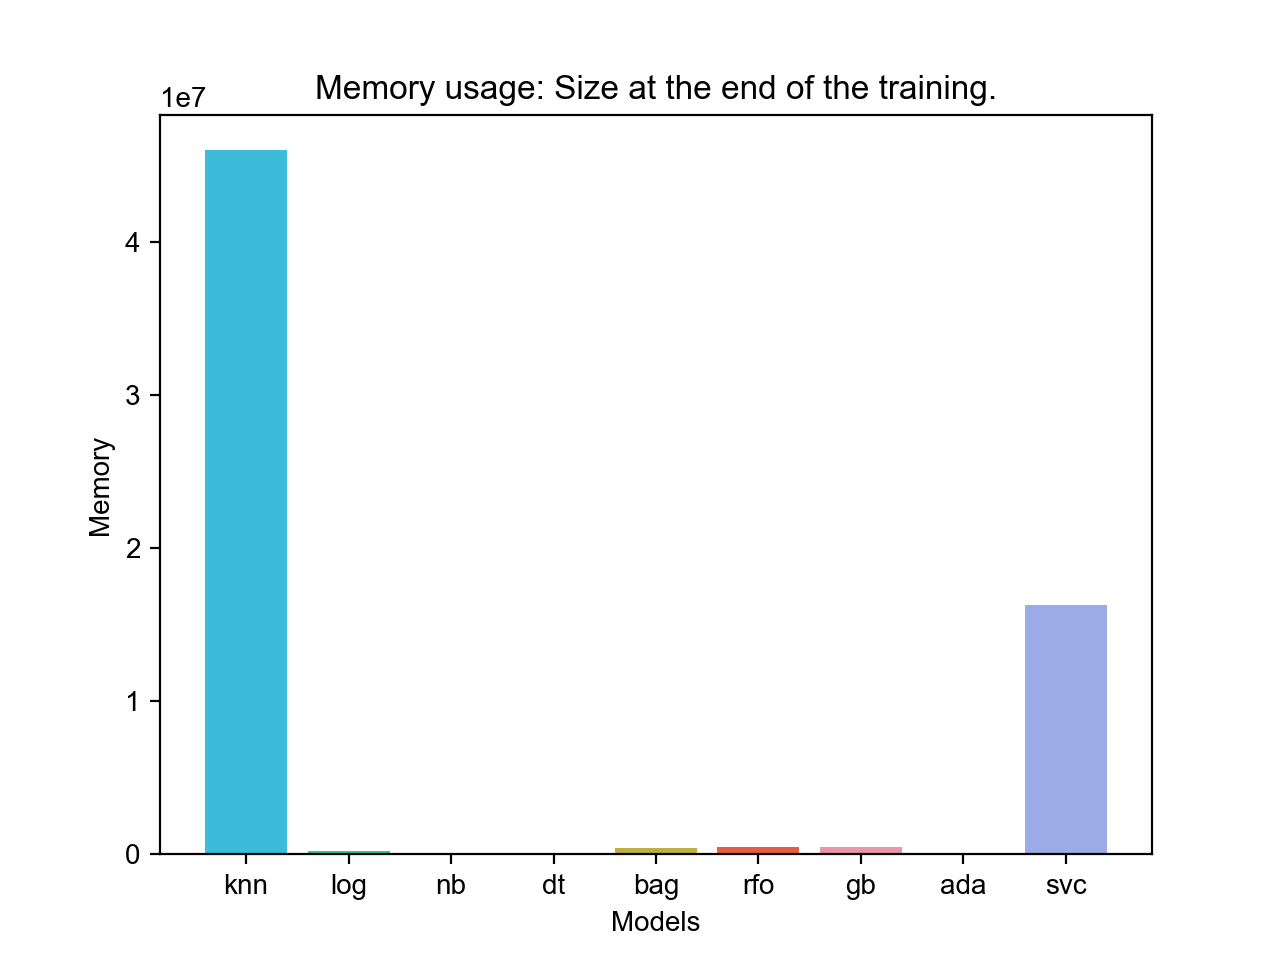

knn : 46014154
log : 2109377
nb : 22595075
dt : 1087451
bag : 17260571
rfo : 15351354
gb : 11142082
ada : 3022777
svc : 90488724


<IPython.core.display.Javascript object>


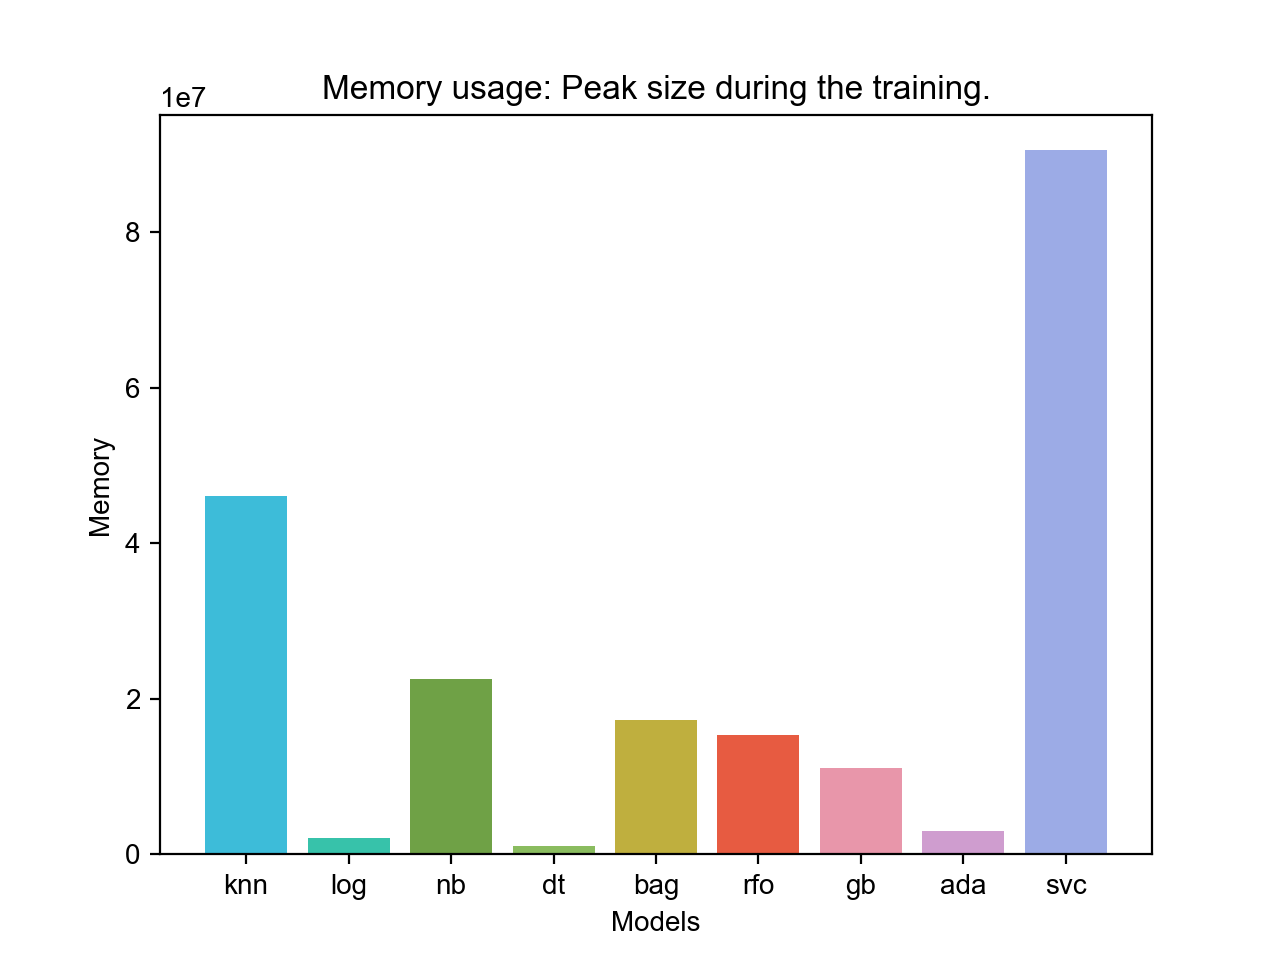

In [24]:
if (mode == 'Evaluating') | (mode == 'All'):
    #Evaluation: Memory
    colors = color_names()
    plt.figure()
    for name, fs in fs_train.items():
        plt.bar(name, fs, label=name, color = colors[name])
        print(name, ':', fs)
    plt.title('Memory usage: Size at the end of the training.')
    plt.xlabel('Models')
    plt.ylabel('Memory')
    plt.savefig('firstsize.png',dpi=300)
    plt.show()

    plt.figure()
    for name, fp in fp_train.items():
        plt.bar(name, fp, label=name, color = colors[name])
        print(name, ':', fp)
    plt.title('Memory usage: Peak size during the training.')
    plt.xlabel('Models')
    plt.ylabel('Memory')
    plt.savefig('fisrtpeak.png',dpi=300)
    plt.show()

knn :  0.06886138518651326
log :  1.890261967976888e-05
nb :  0.00030538241068522133
dt :  1.6148885091145834e-05
bag :  0.003958117961883545
rfo :  0.003127415974934896
gb :  0.00031026999155680336
ada :  3.3513704935709635e-05
svc :  0.08024735450744629


<IPython.core.display.Javascript object>


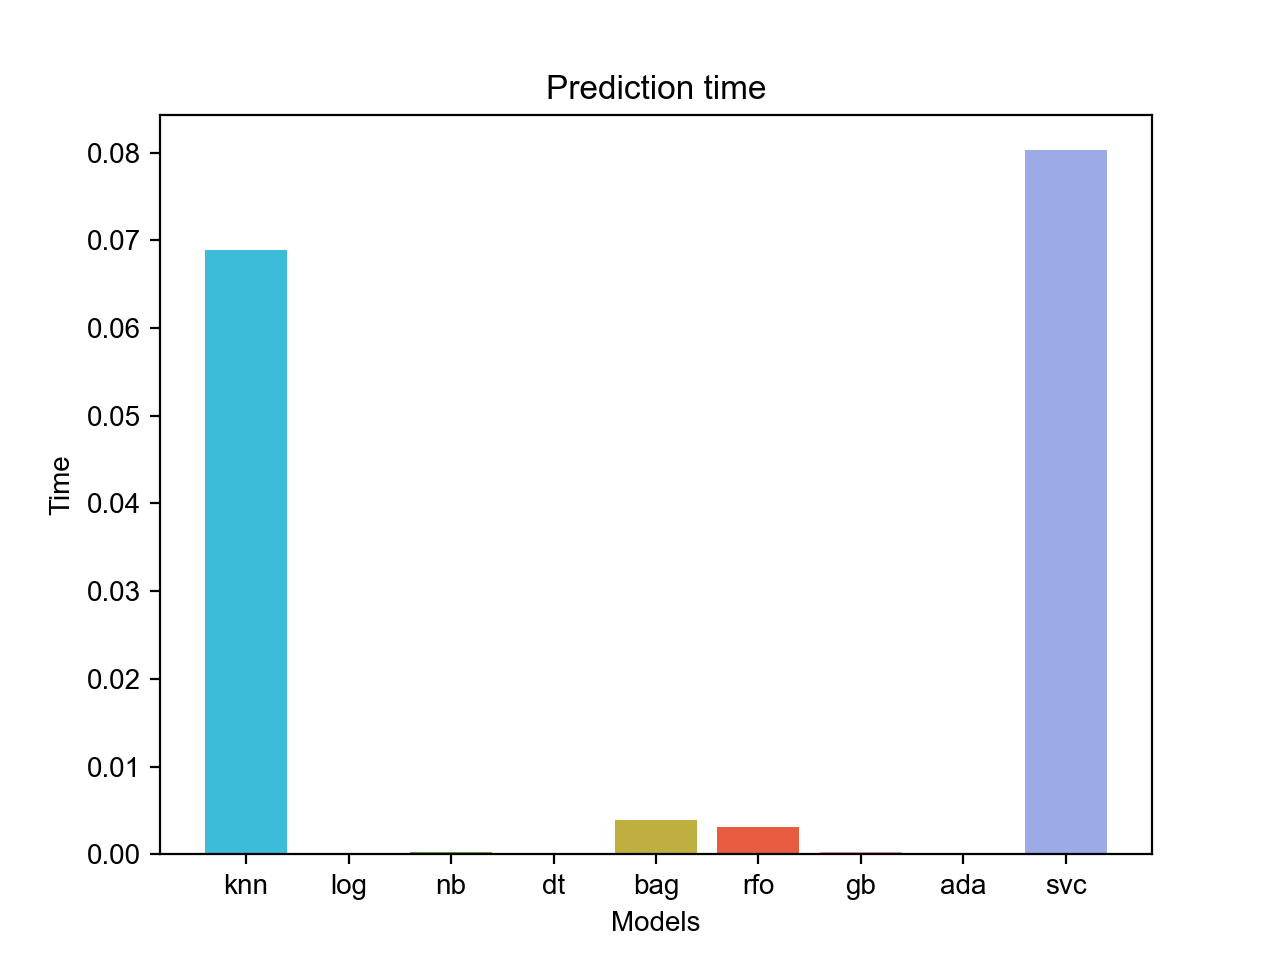

In [25]:
if (mode == 'Evaluating') | (mode == 'All'):
    #Evaluation: Predicting time (on test data)
    plt.figure()
    colors = color_names()
    for name, tt in tt_pred.items():
        plt.bar(name, tt, label=name, color=colors[name])
        print(name, ': ', tt)
    plt.title('Prediction time')
    plt.xlabel('Models')
    plt.ylabel('Time')
    plt.savefig('PredictionTime.png',dpi=300)
    plt.show()

In [26]:
if (mode == 'Evaluating') | (mode == 'All'):
    #Evaluation (using cross-validation)
    models_acc_cv_train = {}
    models_acc_cv_test = {}
    tqdm.pandas()
    for name, model in tqdm(models_dic.items()):
        acc_cv_train = cross_val_score(model, X_train_reduced, y_train, cv=10)*100
        acc_cv_test = cross_val_score(model, X_test_reduced, y_test, cv=10)*100
        models_acc_cv_train[name]= acc_cv_train
        models_acc_cv_test[name]= acc_cv_test

  0%|          | 0/9 [00:00<?, ?it/s]

/Users/jimenaspi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jimenaspi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jimenaspi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jimenaspi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jimenaspi/opt/anaconda3/lib/python3.8/site-packages/sklearn/l

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


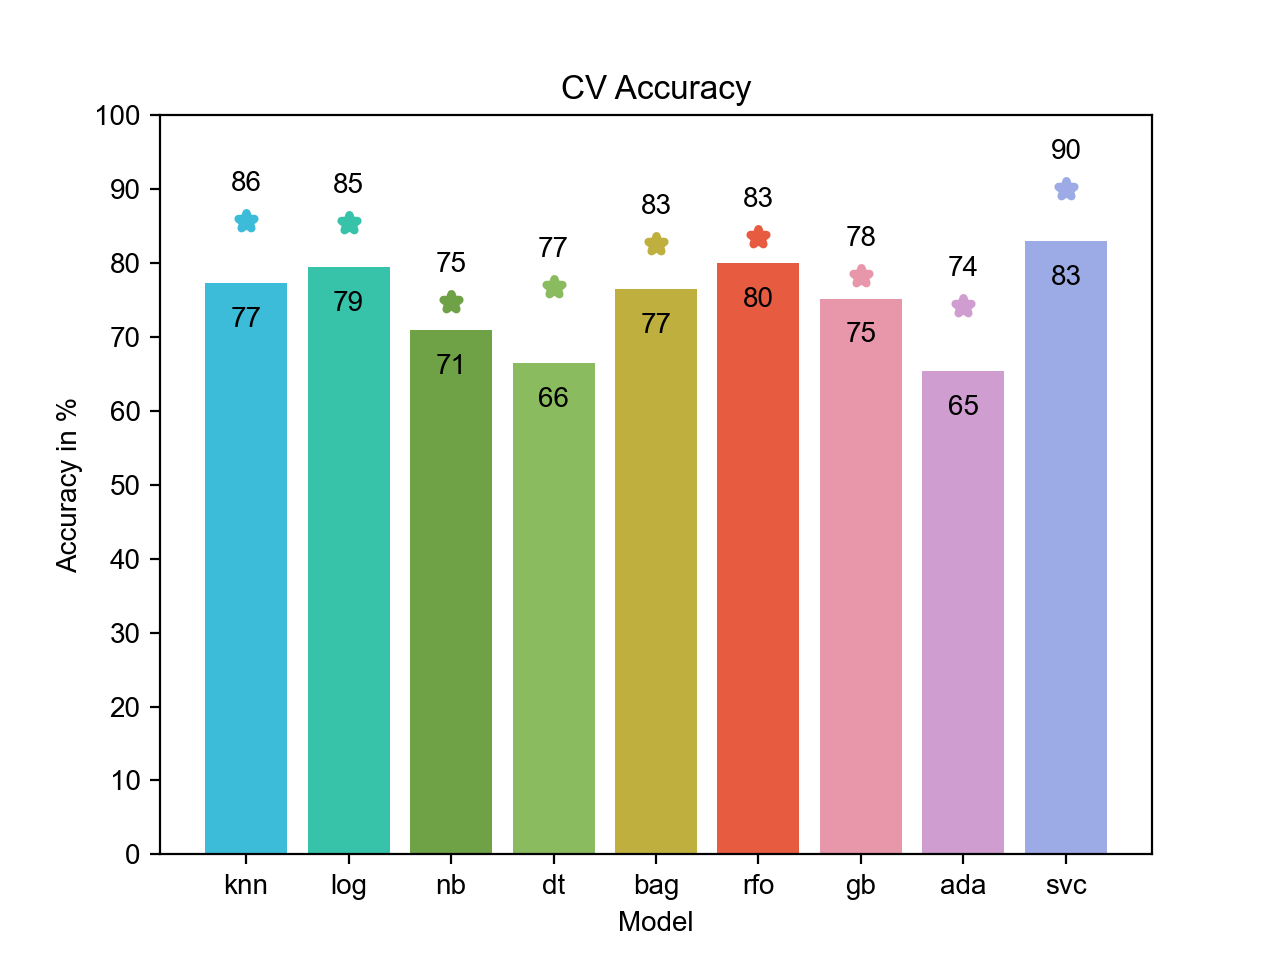

In [27]:
if (mode == 'Evaluating') | (mode == 'All'):
    plt.figure()
    for name, acc in tqdm(models_acc_cv_test.items()):
        plt.bar(name, acc.mean(), label = name, color = colors[name])
        plt.text(name, acc.mean()-5, '{:.0f}'.format(acc.mean()), horizontalalignment='center', 
                 verticalalignment='center')
    for name, acc in tqdm(models_acc_cv_train.items()):
        plt.scatter(name, acc.mean() ,label = name, color = colors[name], marker = '*', linewidths = 3)
        plt.text(name, acc.mean()+5, '{:.0f}'.format(acc.mean()), horizontalalignment='center', 
                 verticalalignment='center')
    n = 100
    plt.yticks(np.linspace(0, n, n//9))
    plt.xlabel('Model')
    plt.ylabel('Accuracy in %')
    plt.title('CV Accuracy')
    plt.savefig('AccuracyCVTrainTestData.png',dpi=300)
    plt.show() #Compare with accuracy on training data

In [28]:
if (mode == 'Evaluating') | (mode == 'All'):
    for name, acc_cv in models_acc_cv_train.items():
        print('model {} with cross-val acc avg {:.4f}' .format(name, acc_cv.mean()))

model knn with cross-val acc avg 85.6933
model log with cross-val acc avg 85.3633
model nb with cross-val acc avg 74.7867
model dt with cross-val acc avg 76.8167
model bag with cross-val acc avg 82.5667
model rfo with cross-val acc avg 83.4967
model gb with cross-val acc avg 78.2967
model ada with cross-val acc avg 74.1900
model svc with cross-val acc avg 90.0467


In [29]:
if (mode == 'Evaluating') | (mode == 'All'):
    #We will use 'predictions' dict that is already stored.
    #It contains predictions made with the models using Test data.
    #Stored in the way: {'knn': array([1, 8, 1, ..., 2, 7, 6], 
    #dtype=uint8),  'log': array([1,...])...}
    class_report = {}
    for name, predicted in predictions.items():
        print('Performance of {} model' .format(name))
        print(metrics.classification_report(label_test, predicted))
        class_report[name] = metrics.classification_report(label_test, predicted, 
                                                           output_dict=True)
        print('\n')

Performance of knn model
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       192
           1       0.99      0.99      0.99       184
           2       0.74      0.73      0.73       206
           3       0.87      0.82      0.84       207
           4       0.72      0.72      0.72       220
           5       1.00      0.84      0.91       190
           6       0.58      0.62      0.60       190
           7       0.87      0.95      0.91       192
           8       0.97      0.95      0.96       227
           9       0.88      0.95      0.91       192

    accuracy                           0.83      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.83      0.84      2000



Performance of log model
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       192
           1       0.97      0.98      0.98       184
           2       0.73   

<IPython.core.display.Javascript object>


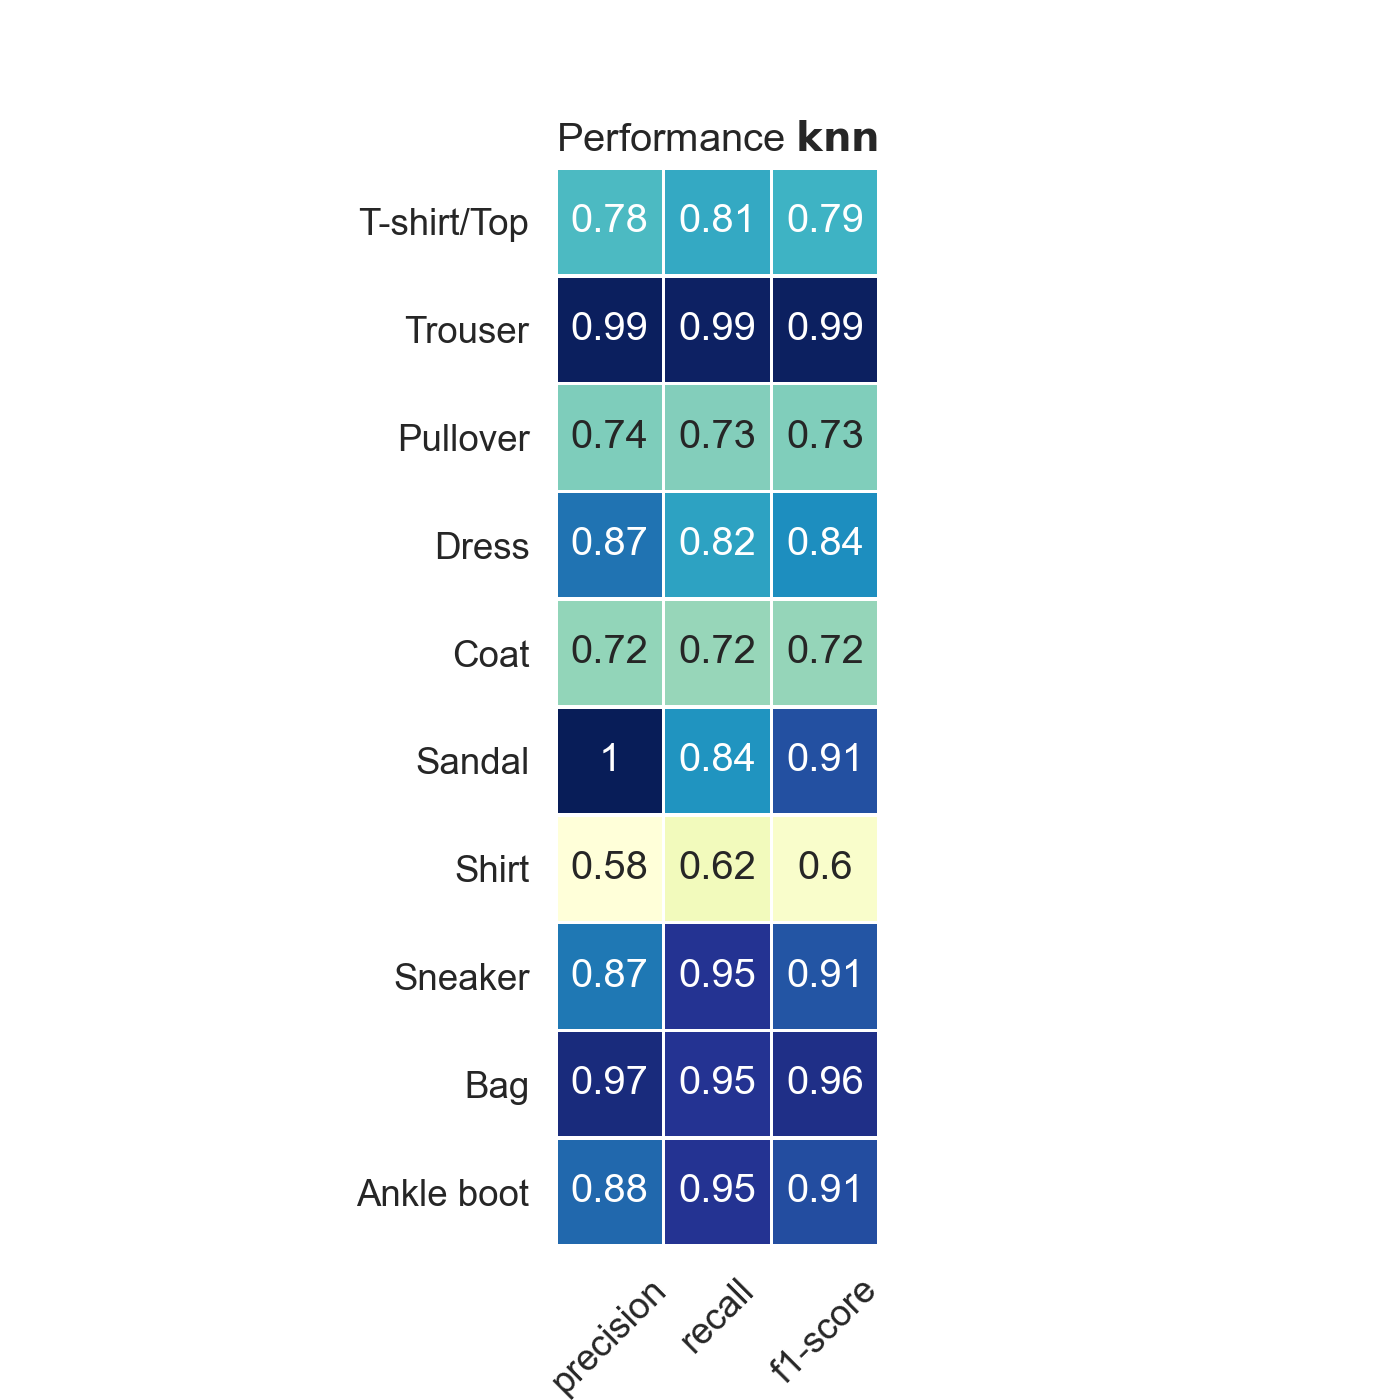

<IPython.core.display.Javascript object>


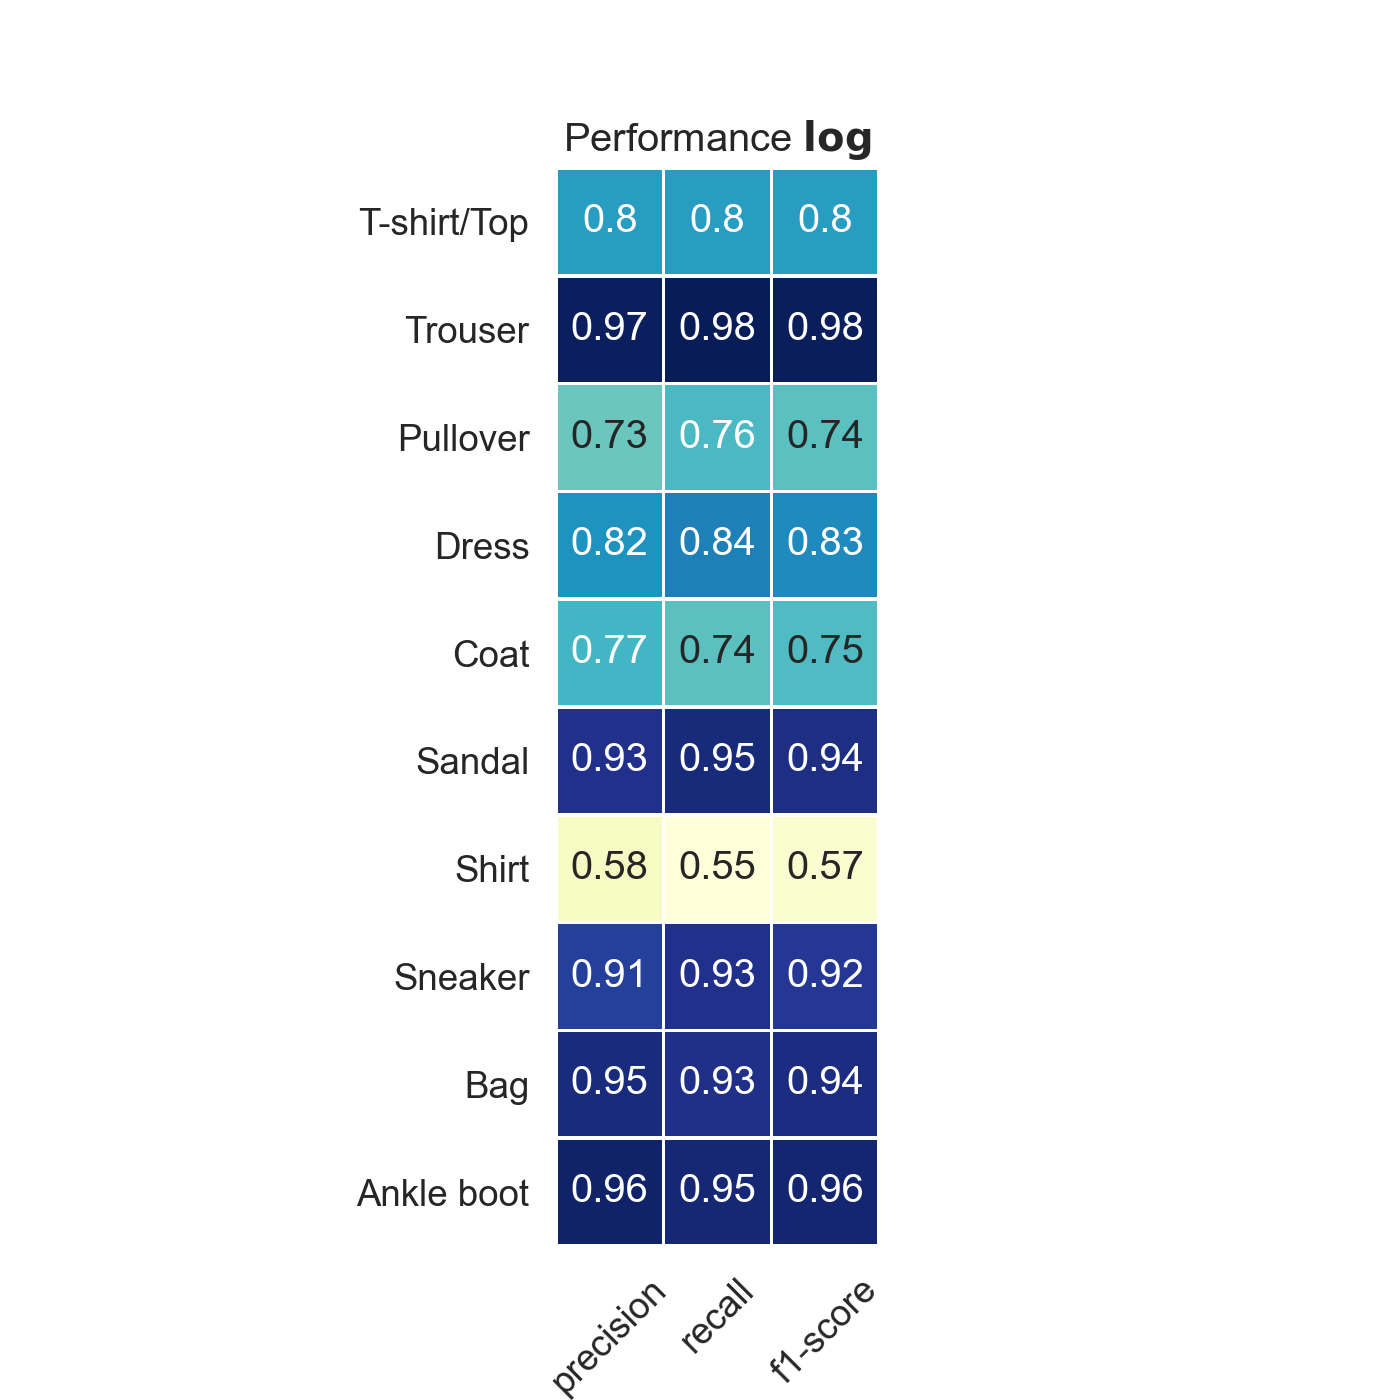

<IPython.core.display.Javascript object>


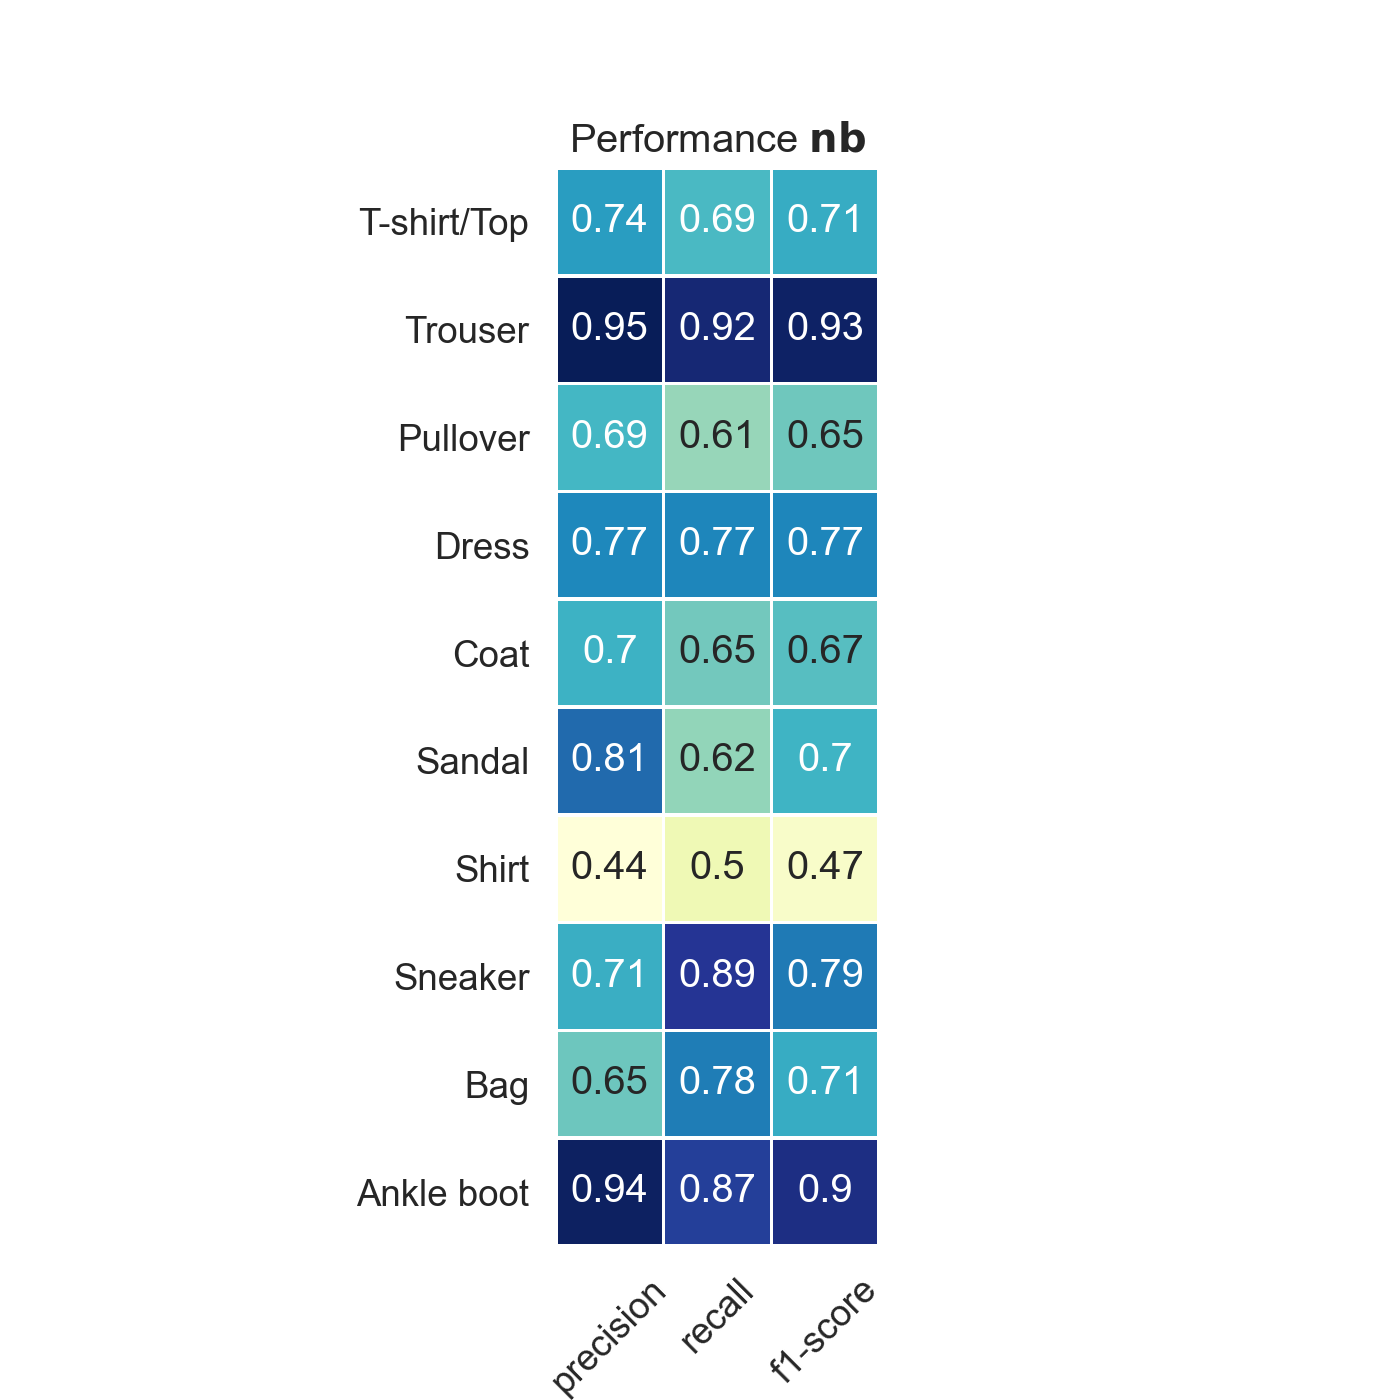

<IPython.core.display.Javascript object>


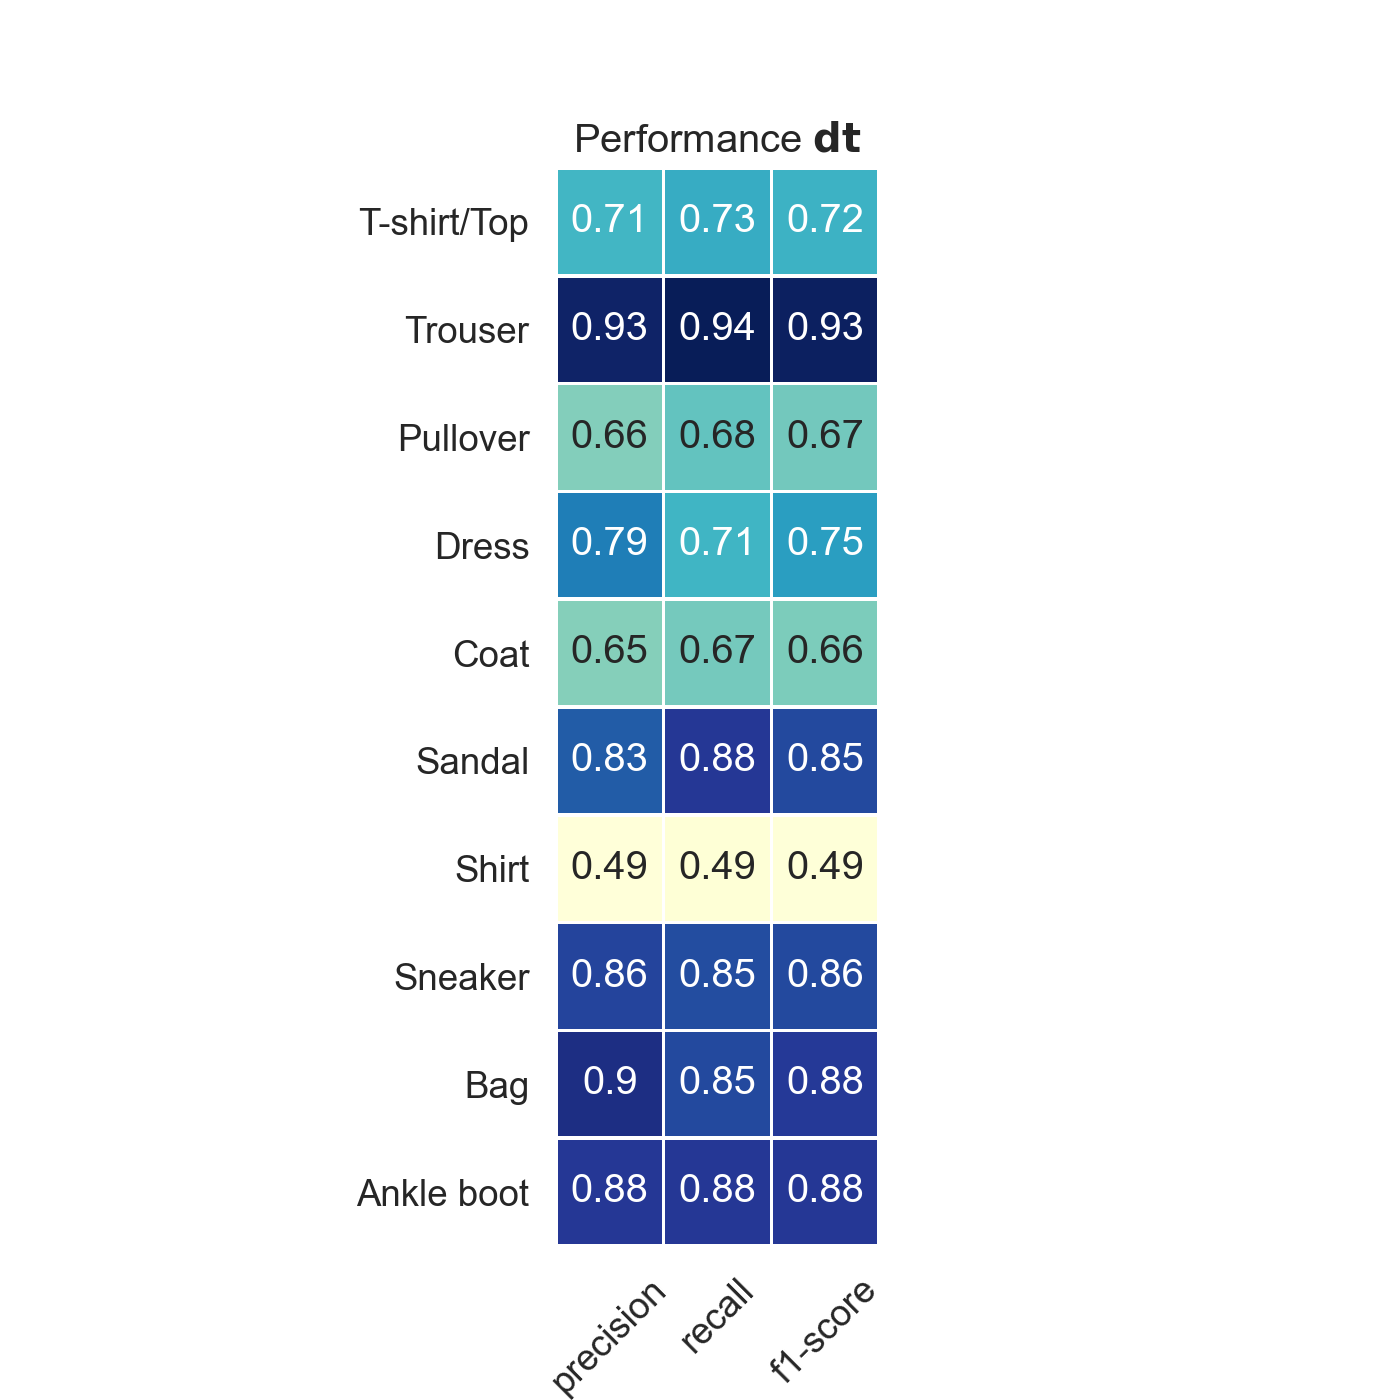

<IPython.core.display.Javascript object>


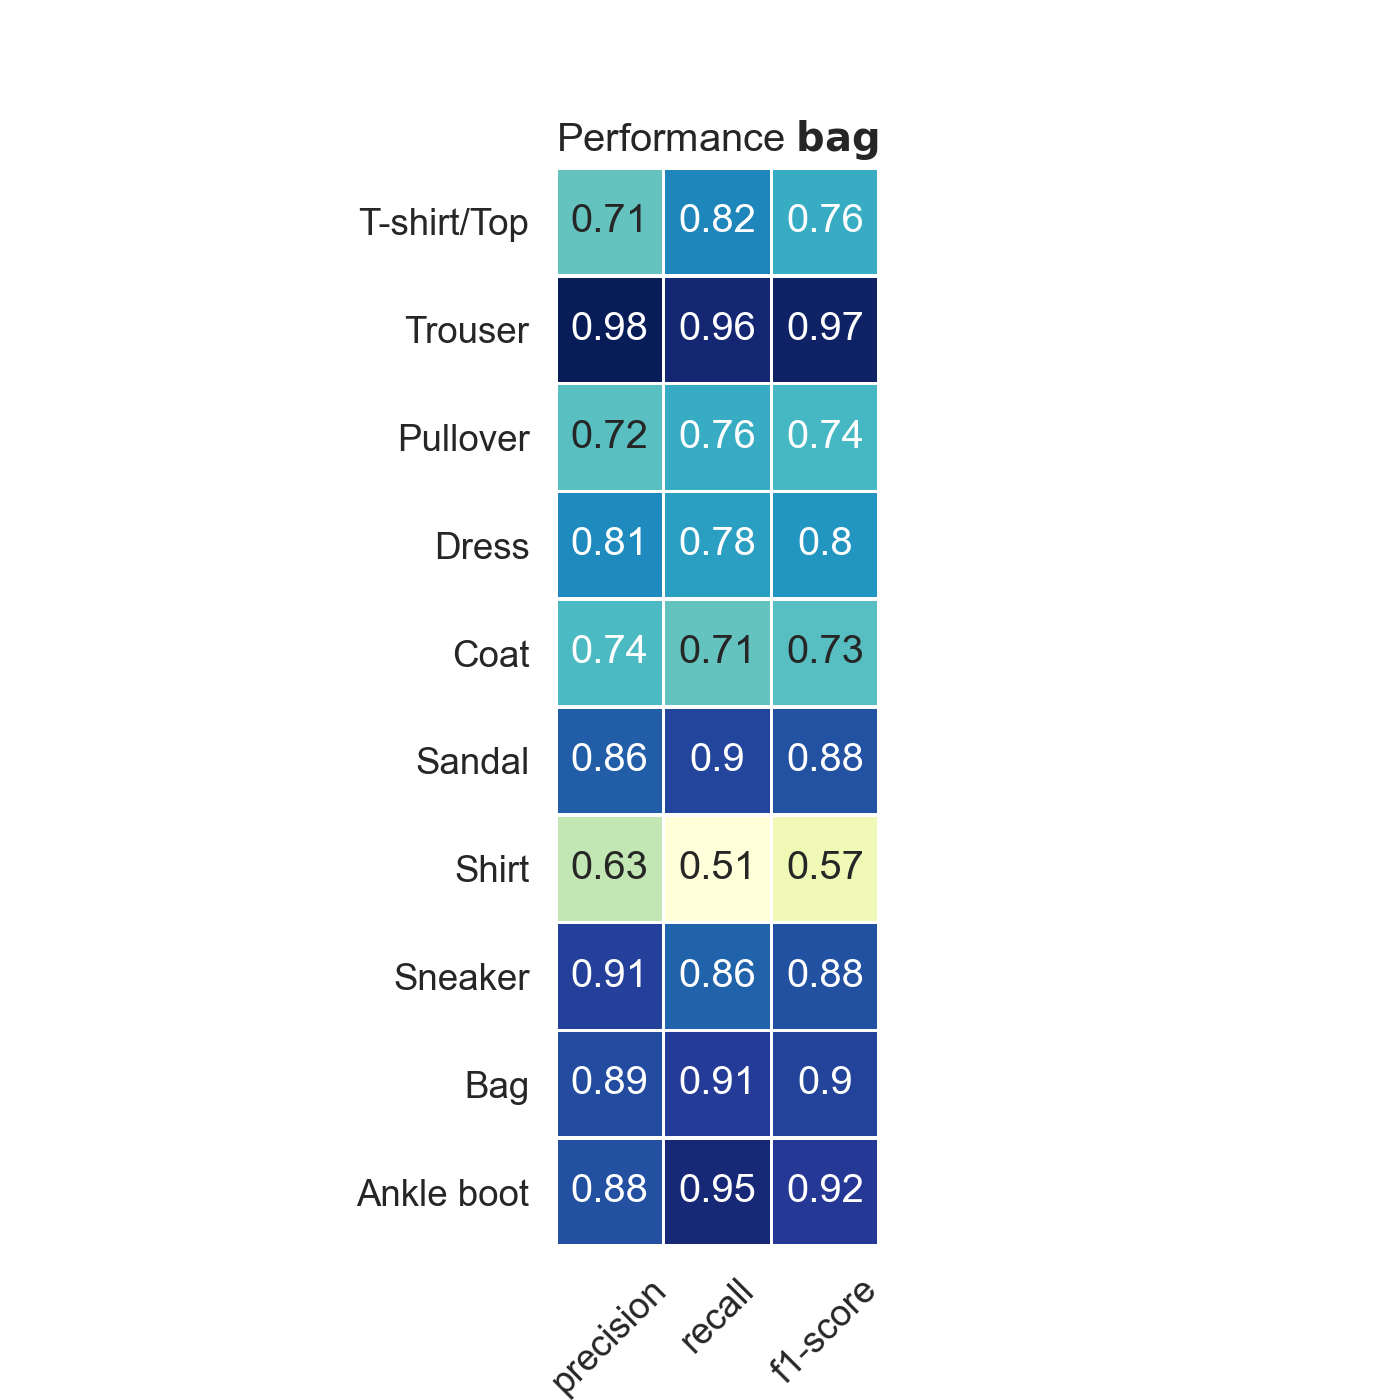

<IPython.core.display.Javascript object>


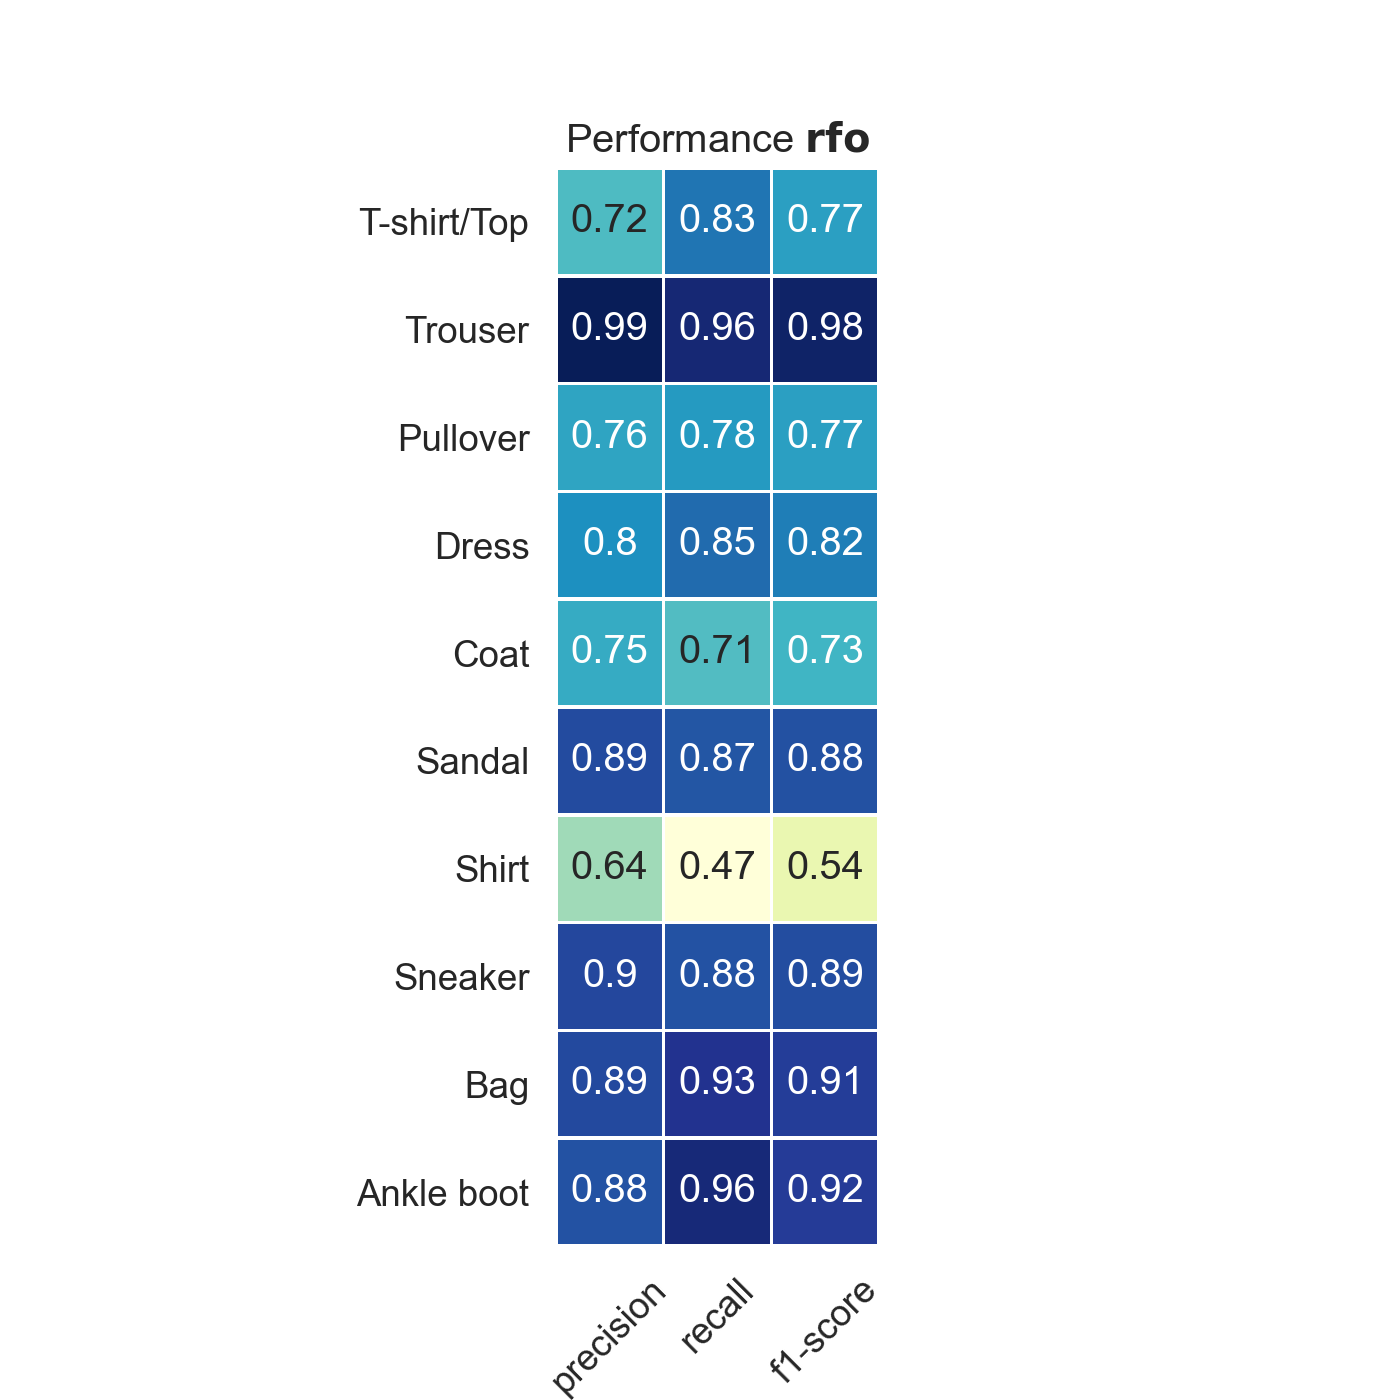

<IPython.core.display.Javascript object>


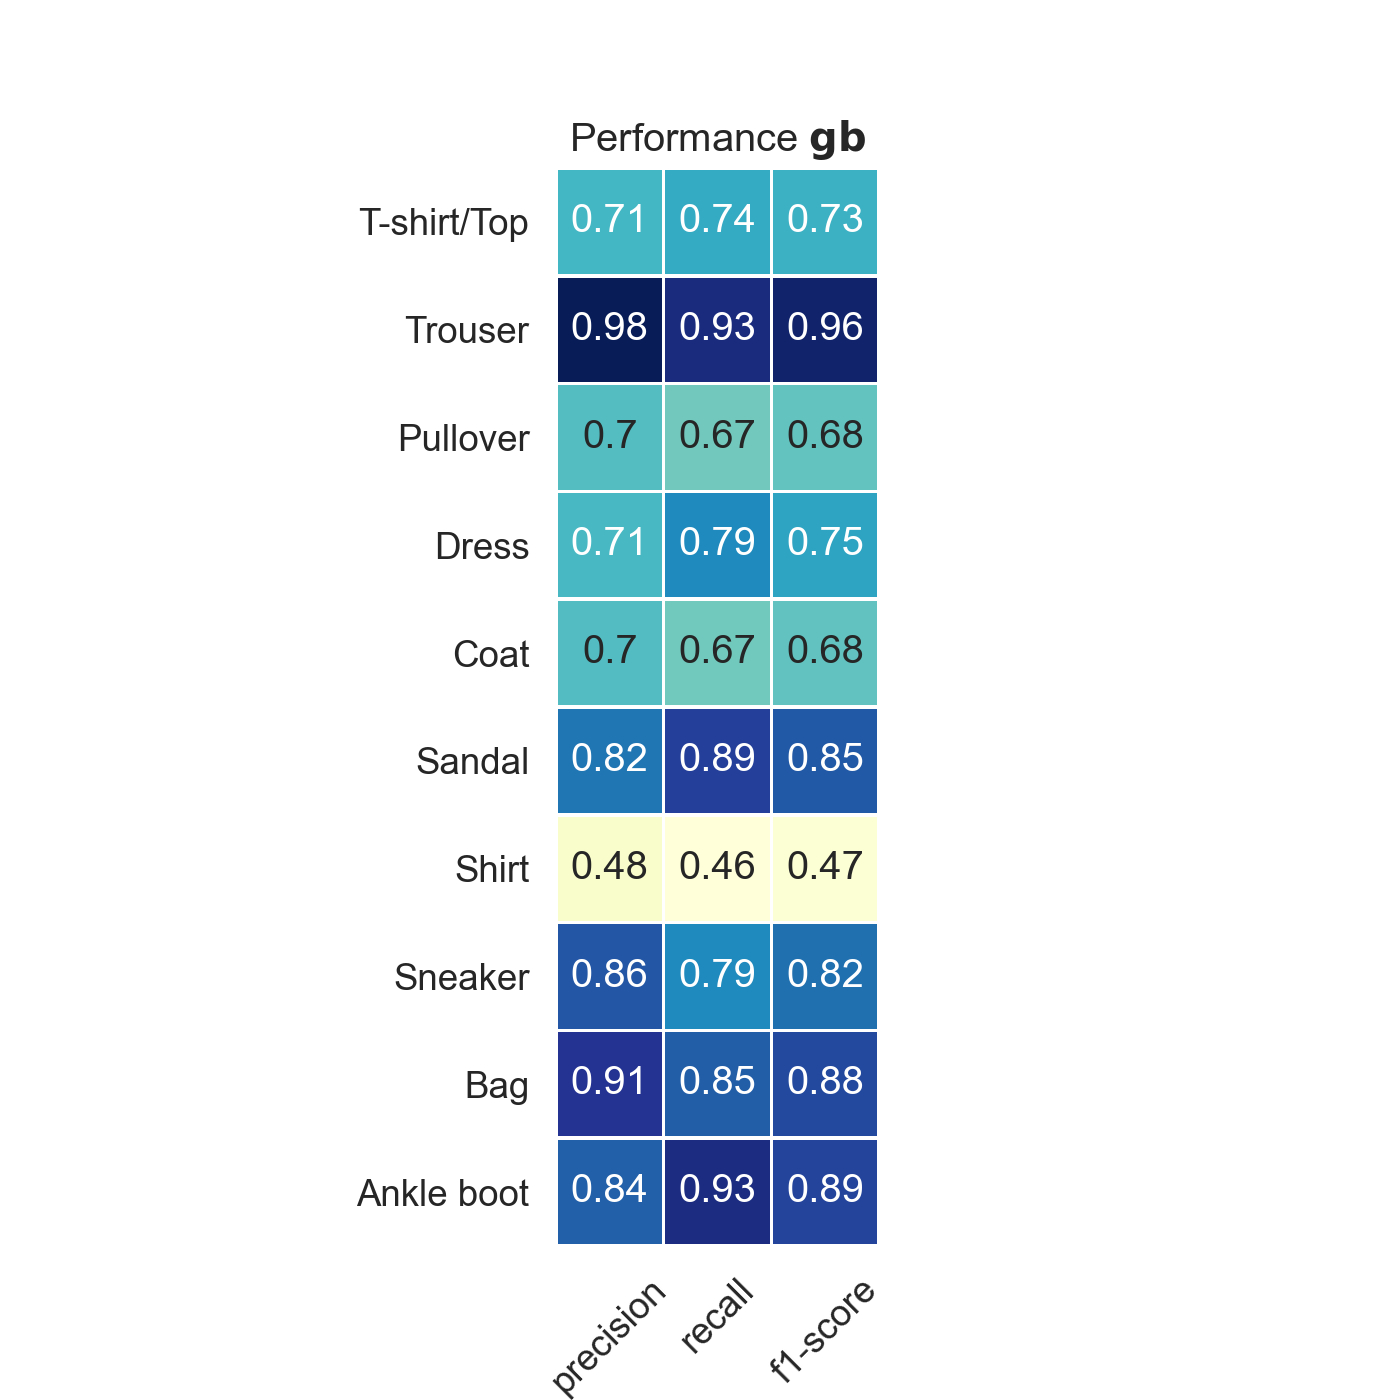

<IPython.core.display.Javascript object>


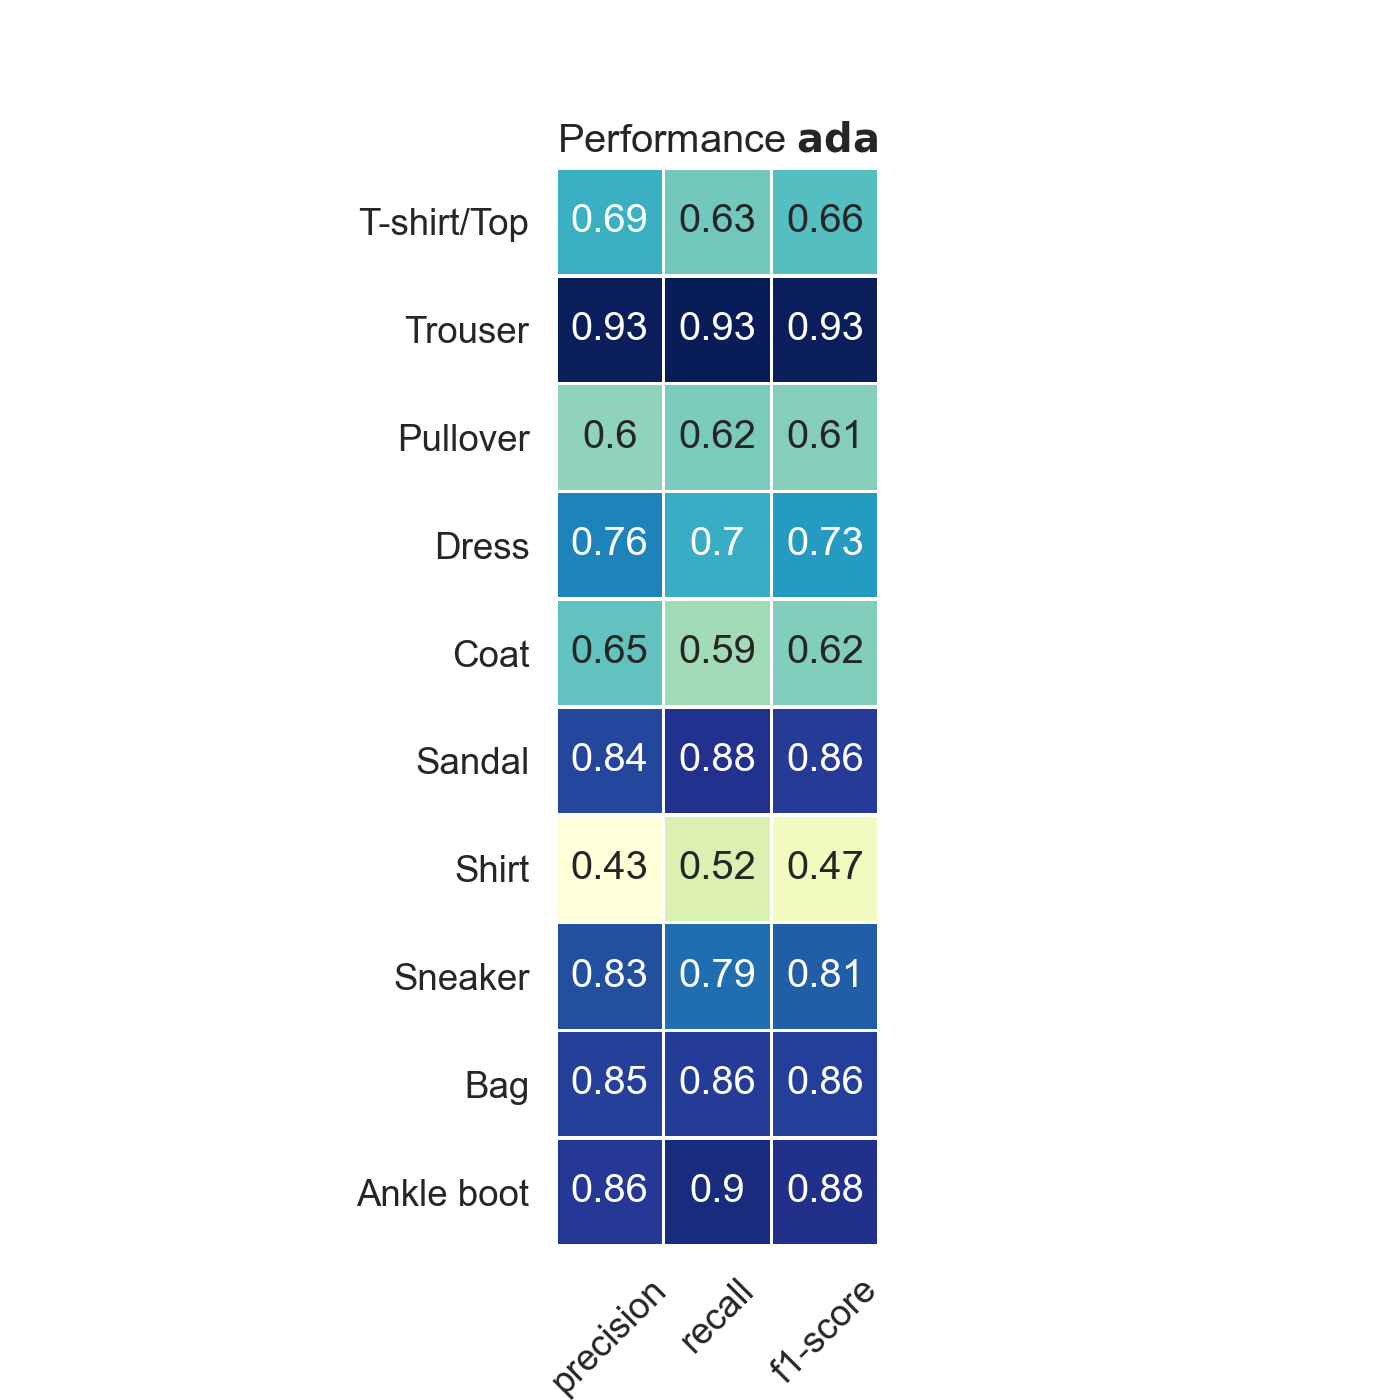

<IPython.core.display.Javascript object>


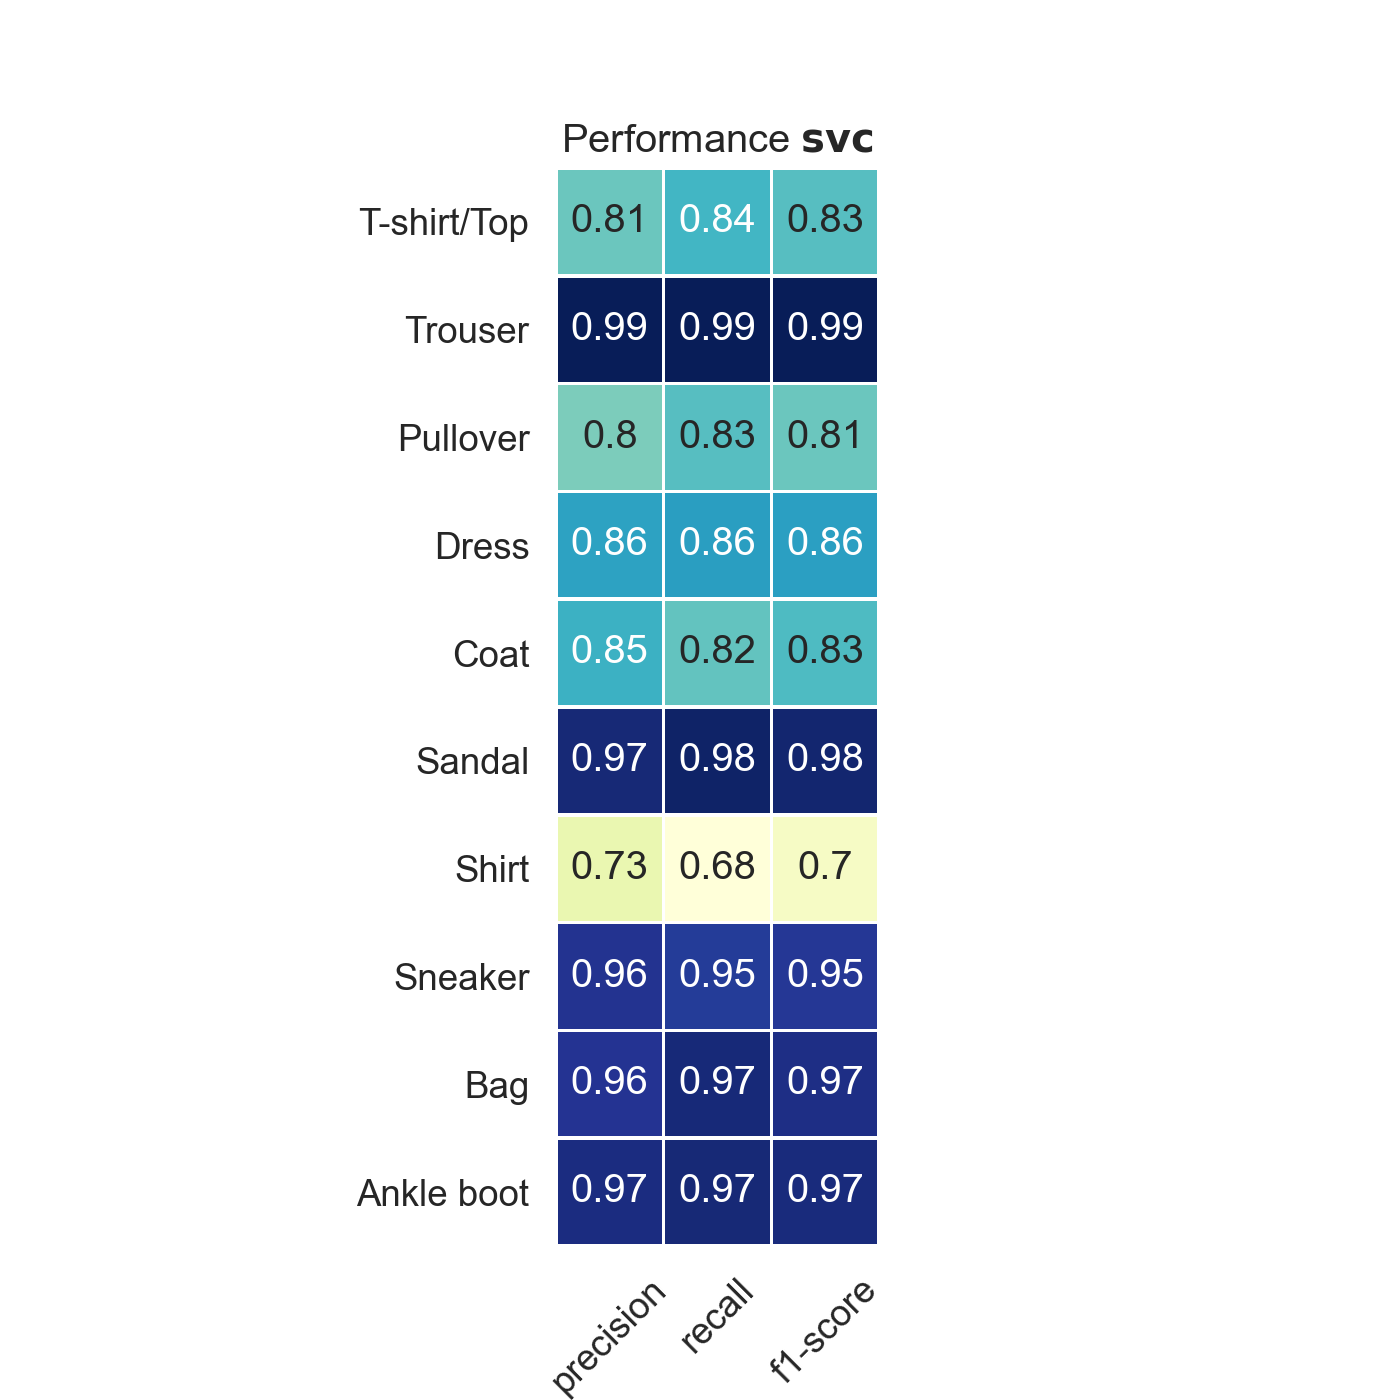

In [30]:
if (mode == 'Evaluating') | (mode == 'All'):

    for name, report in class_report.items():
        report  = pd.DataFrame(report)
        tc = type_classes()
        plt.figure()
        sns.set(font_scale=1.2)
        label_class = list(tc.values())
        ax0 = plt.axes()
        ax1 = sns.heatmap(report.iloc[:-1, :-3].T, annot=True, 
                          yticklabels= label_class,cmap="YlGnBu",linewidths=1, 
                          cbar=0, square=True, ax=ax0)
        plt.xticks(rotation=45) 
        r'non-bold part of title, $R^2$: $\bf{{{a}}}$'
        ax1.set_title(r'Performance $\bf{{{}}}$'.format(name))
        figure = plt.gcf()  
        figure.set_size_inches(7, 7)
        plt.savefig('Performance'+name+'.png',dpi=300)
        plt.show()

# Output using the Best Classifier

In [18]:
def extract_data_final():
    '''It returns the data'''

    file = ['./Input/train/images_training.h5','./Input/train/labels_training.h5']
    column = ['datatrain','labeltrain']
    
    with h5py.File(file[0],'r') as H:
        data_train = np.copy(H[column[0]])
    with h5py.File(file[1],'r') as H:
        label_train = np.copy(H[column[1]])

    #Check this!
    file = ['./Input/test/images_testing.h5','./Input/test/labels_testing.h5'] 
                                                                    
    column = ['datatest','labeltest']
    
    with h5py.File(file[0],'r') as H:
        data_test = np.copy(H[column[0]])
   # with h5py.File(file[1],'r') as H:
        #label_test = np.copy(H[column[1]])

    return data_train, label_train, data_test#, label_test

In [20]:
if (mode == 'Best_Classifier') | (mode == 'All'):
    '''To output the predictions'''

    #Extract the data
    #X_train, y_train, X_test, y_test = prepare_data(True) #to test with the labelled data
    X_train, y_train, X_test = extract_data_final()
    
    #Pre-Process the data
    n_components = 188 #Will explain 95% of the variance.

    pca = prepare_pca(X_train, n_components)
    pca.fit(X_train, y_train)

    X_train_reduced = pca.transform(X_train)
    X_test_reduced = pca.transform(X_test)
    
    #use the best model that we have:
    best_model = 'svc'
 
    model, tt, mi, ts, ft, fps = train(best_model, X_train_reduced, y_train)
    
    output = model.predict(X_test_reduced)  #the output is y_pred
    
    with h5py.File('Output/predicted_labels.h5','w') as H:
        H.create_dataset('Output',data=output)

In [21]:
if  mode == 'All':
    #To check the output.
    file = ['Output/predicted_labels.h5']
    with h5py.File(file[0],'r') as H:
            out = np.copy(H['Output'])
    print(out)
    print(out.shape)

[1 8 1 ... 7 0 0]
(5000,)
